## Initialize HW and constants

In [1]:
import sys
sys.path.append("gpib_instrument_control")
import hp_3478a
import hp_8700_series_vna
import numpy as np
import time
import yig_controller_test
import matplotlib.pyplot as plt
import scipy.io as sio
import skrf.network
import yig_controller_test


plt.rcParams['figure.figsize'] = [15, 10]

#Instruments and devices
yigControllerPort='/dev/ttyUSB0'
vna = hp_8700_series_vna.Hp8753A()
curMeter = hp_3478a.Hp3478A()
yc = yig_controller_test.YigController(yigControllerPort)


Waiting for init... Done


In [2]:
#Constants and auxillary functions
fMin=np.array([0.6, 1, 2, 4, 8, 12])*1e9
fMax=np.array([1,   2, 4, 8, 12, 18])*1e9
yigDriver=yc.yigA
switch=yc.switchA


hardwareDescription='initial test of version 3 of pcb. Strapped mux2b since it was unconnected. Fan mounted correctly. Replaced u15 opamp that had gone bad... New gapfiller'
hardwareRevision='3.1.1'

#reset yig filters
yc.yigB.set(0,0)
yc.yigA.set(6,0)
yc.yigB.set(7,0)

if yigDriver==yc.yigA:
    driverChannel='A'
if yigDriver==yc.yigB:
    driverChannel='B'
    
def revFileName(baseName):
    global hardwareRevision
    return '%s_channel_%s_rev_%s.mat'%(baseName, driverChannel, hardwareRevision)

def saveData(baseName, baseData):
    global hardwareDescription
    global hardwareRevision
    dataToSave=baseData;
    dataToSave['hardwareDescription']=hardwareDescription
    sio.savemat(revFileName(baseName), dataToSave)

def loadData(baseName):
    global hardwareRevision
    return sio.loadmat(revFileName(baseName))
    

## Measure current tuning ranges

In [3]:
wr = np.linspace(-32768, 32767, 32, dtype=np.int16)
yigChs = range(6)
#zeros=[0, 0, 0, 0, 0, 0]
zeros = []
channels=[]
currentMtx = None;
for c in yigChs:
    print(c)
    yigDriver.set(c, wr[0])
    time.sleep(5);
    current=[]
    for w in wr:
        yigDriver.set(c, w);
        time.sleep(0.1)
        for i in range(3):
            curMeter.readValue()
        current.append(curMeter.readValue())
    channels.append(current)
    currentMtx = yig_controller_test.stackVector(currentMtx, current)
    yigDriver.set(6, 0)
    time.sleep(3)
    zeros.append(curMeter.readValue())

saveData('current_sweep', {'current':currentMtx, 'yigChs':yigChs, 'tuningWordRange': wr});


0
1
2
3
4
5


In [4]:
import scipy.io as sio
saveData('yig_filter_driver_current_data', {'zeros':zeros, 'channels':channels, 'wr':wr})

In [5]:
d=loadData('yig_filter_driver_current_data')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

In [6]:
print(zeros)

[-7.e-06 -6.e-06 -6.e-06 -8.e-06 -7.e-06 -1.e-05]


Filter 0 has current from 0.000178 to 0.079126 [A] in control word range -28540 - 30652 [LSB]
Filter 1 has current from 0.000516 to 0.232785 [A] in control word range -28540 - 30652 [LSB]
Filter 2 has current from 0.001216 to 0.545486 [A] in control word range -28540 - 30652 [LSB]
Filter 3 has current from 0.002434 to 0.729518 [A] in control word range -28540 - 11626 [LSB]
Filter 4 has current from 0.002260 to 1.005697 [A] in control word range -28540 - 30652 [LSB]
Filter 5 has current from 0.002291 to 1.006850 [A] in control word range -28540 - 30652 [LSB]


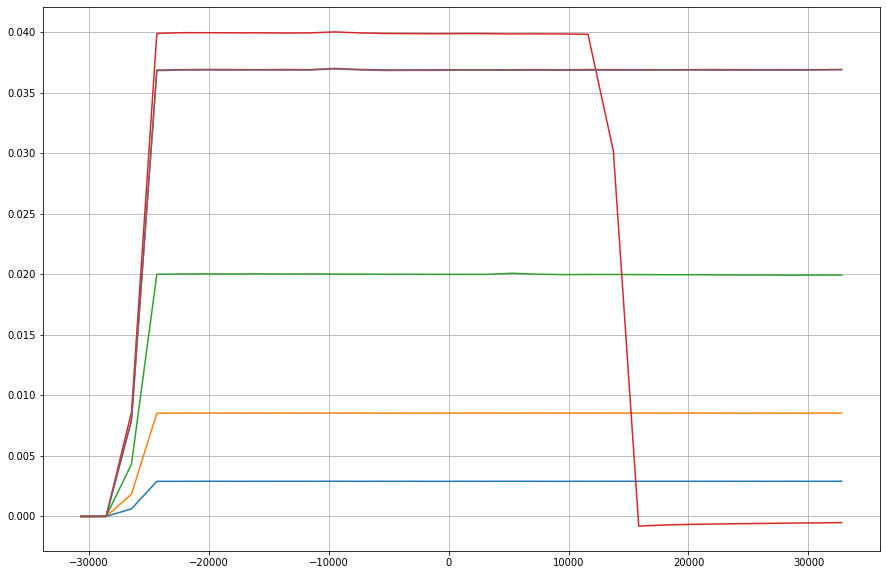

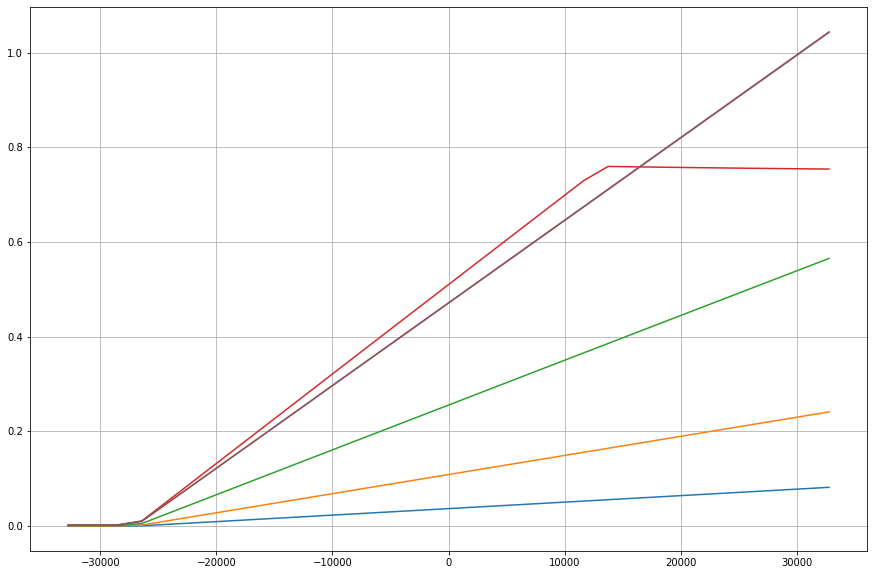

In [7]:
charr = np.array(channels)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class FilterParameters:
    def __init__(self, lc, hc, lw, hw):
        self.lc=lc
        self.hc=hc
        self.lw=lw
        self.hw=hw

        
fParams=[]
for i in range(len(zeros)):
    #avgd = moving_average(np.diff(charr[i,:]), 10)
    avgd = np.diff(charr[i,:])
    plt.figure(1)
    plt.plot(wr[1::],avgd)
    plt.grid(True)
    plt.figure(2)
    plt.plot(wr, charr[i,:])
    plt.grid(True)
    idxs = np.where(avgd>0.0002);
    mii=idxs[0][0]
    mai=idxs[0][-1]
    zc = zeros[i]
    mic=charr[i,mii]-zc
    mac=charr[i,mai]-zc
    #print(idxs[0])
    print("Filter %i has current from %f to %f [A] in control word range %d - %d [LSB]"%(i, mic, mac, wr[mii], wr[mai]))
    fParams.append(FilterParameters(mic, mac, wr[mii], wr[mai]))
    

## Coarse tuning

0.378375 to 1.421550 [GHz]
0.279025 to 4.203350 [GHz]
1.173175 to 9.568250 [GHz]
1.421550 to 10.909475 [GHz]
0.130000 to 17.714950 [GHz]
0.527400 to 17.863975 [GHz]


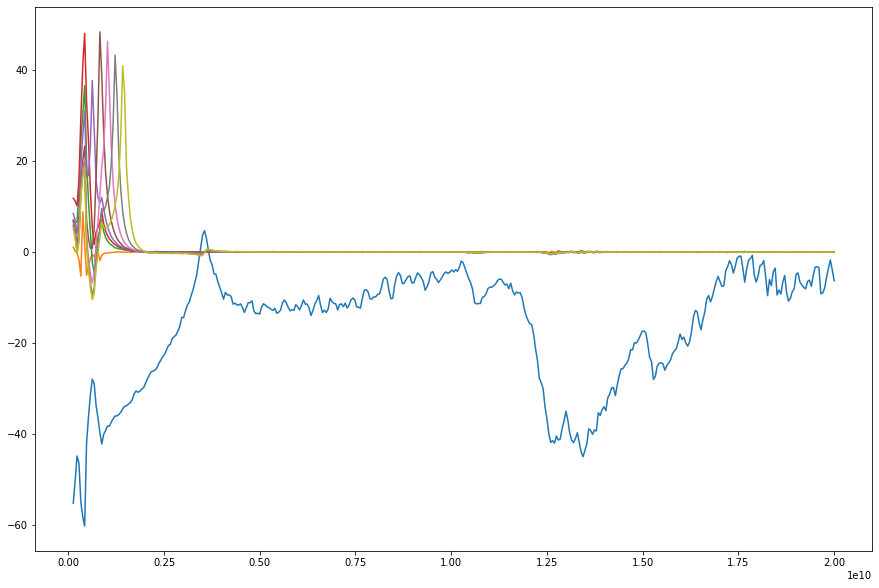

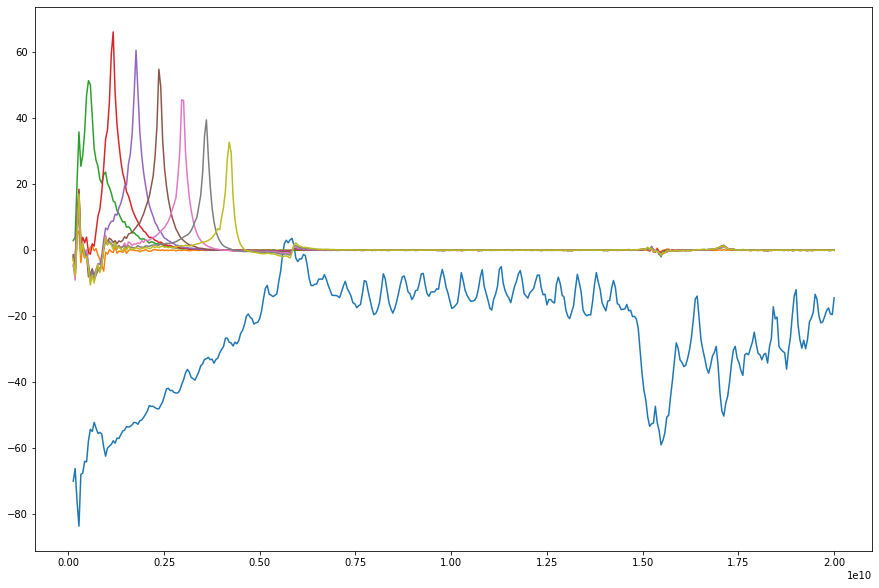

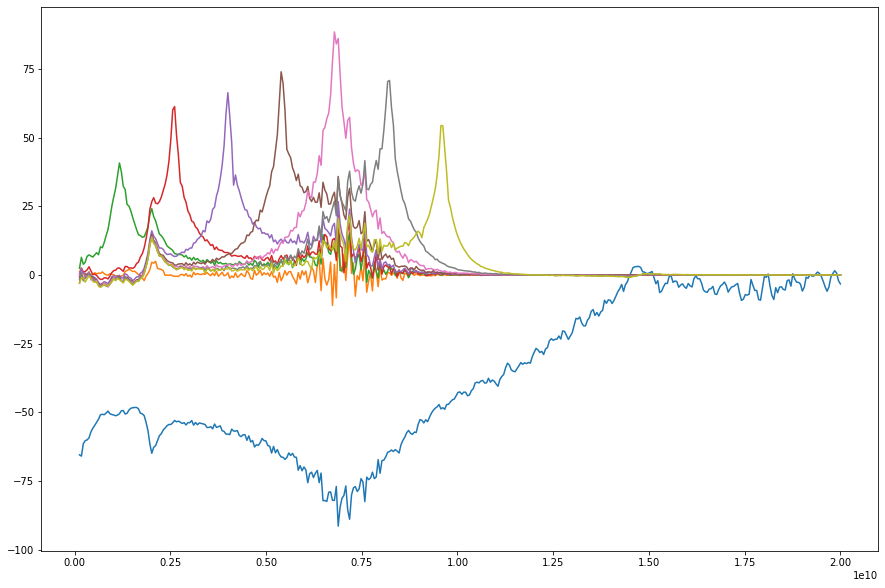

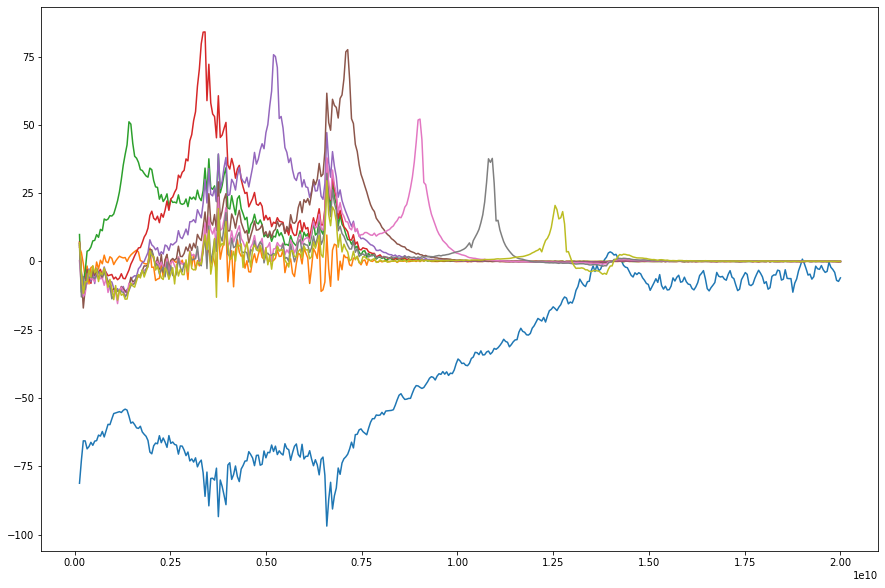

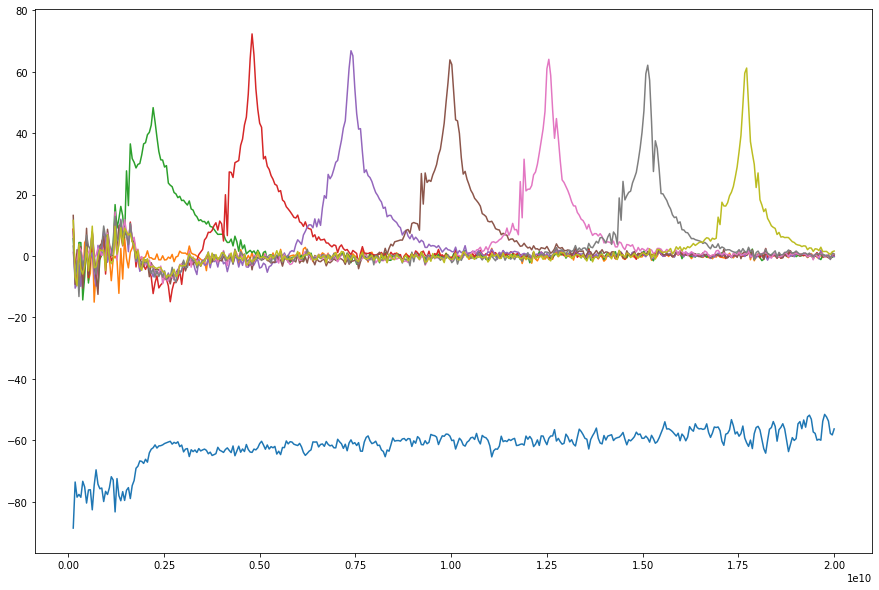

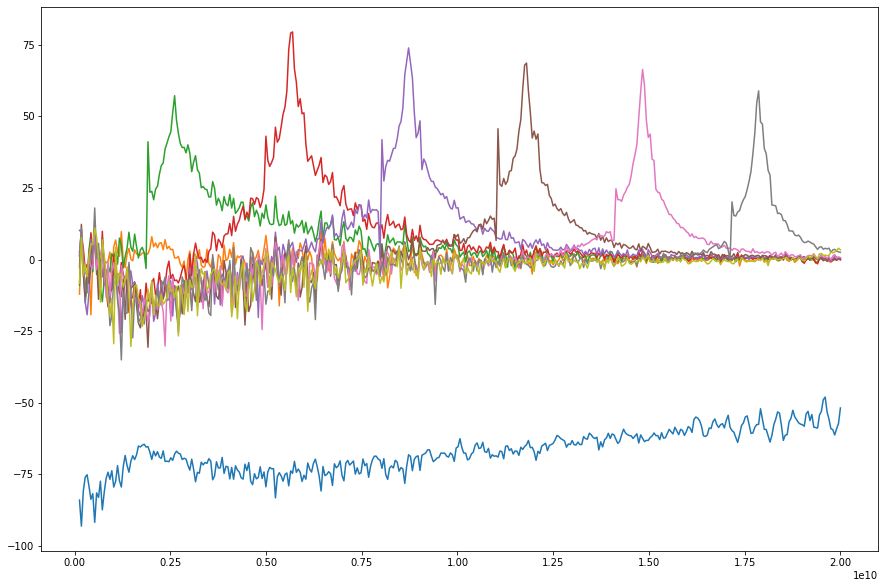

<Figure size 1080x720 with 0 Axes>

In [8]:
vna.setStartFrequency(130e6)
vna.setStopFrequency(20e9)
vna.setPoints(401)

fRanges=[]
for i in range(len(zeros)):
    #print("Filter", i )
    fp = fParams[i]
    switch.set(i+1)
    yigDriver.set(6, 0)
    fax = vna.frequencies()
    base = vna.readSParameter('S21')
    plt.plot(fax, 20*np.log10(np.abs(base)))
    sr = np.linspace(fp.lw, fp.hw, 8)
    freqs=[]
    
    for w in sr:
        yigDriver.set(i, int(w))
        time.sleep(1)
        t = vna.readSParameter('S21')
        #traces.append(t)
        delt = np.abs(t)/np.abs(base)
        freqs.append(fax[np.argmax(delt)])
        plt.plot(fax, 20*np.log10(delt))
    mif=np.min(freqs)
    maf=np.max(freqs)
    #print(freqs)
    #print(np.diff(freqs))
    fRanges.append((mif, maf))
    
    plt.figure()

for fmi, fma in fRanges:
    print("%f to %f [GHz]"%(fmi/1e9, fma/1e9))

import scipy.io as sio
saveData('yig_filter_driver_coarse_frequency', {'fRanges':fRanges})

In [9]:
#Get calibration data
import os.path

if not os.path.exists('cal_through.s2p'):
    calPar=vna.getHighResolutionNetwork(130e6, 20e9, 1e6)
    calPar.plot_s_db()
    calPar.write_touchstone('cal_through.s2p')

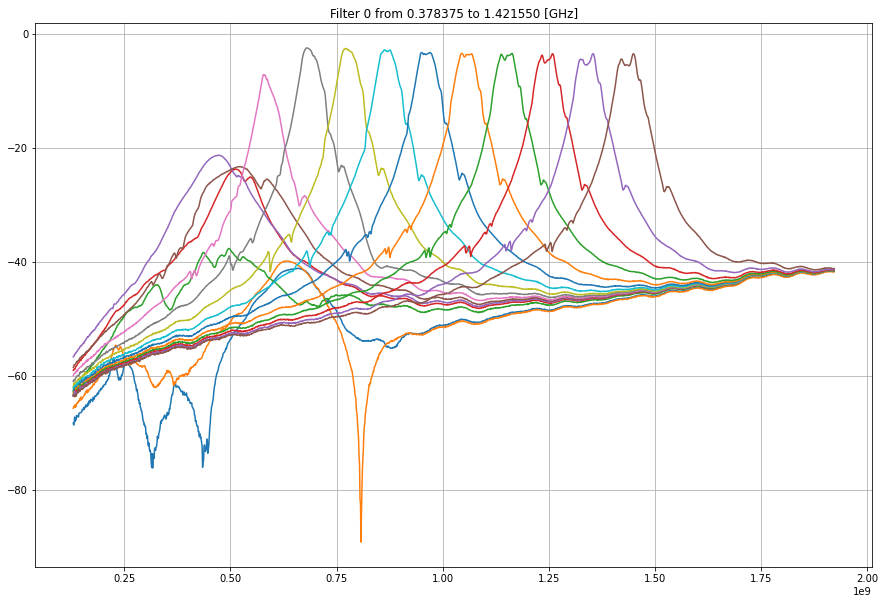

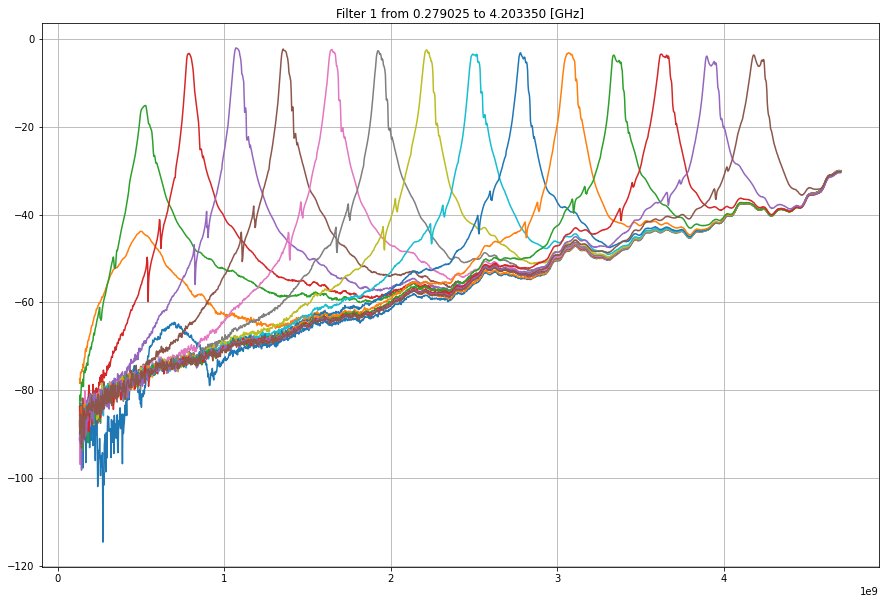

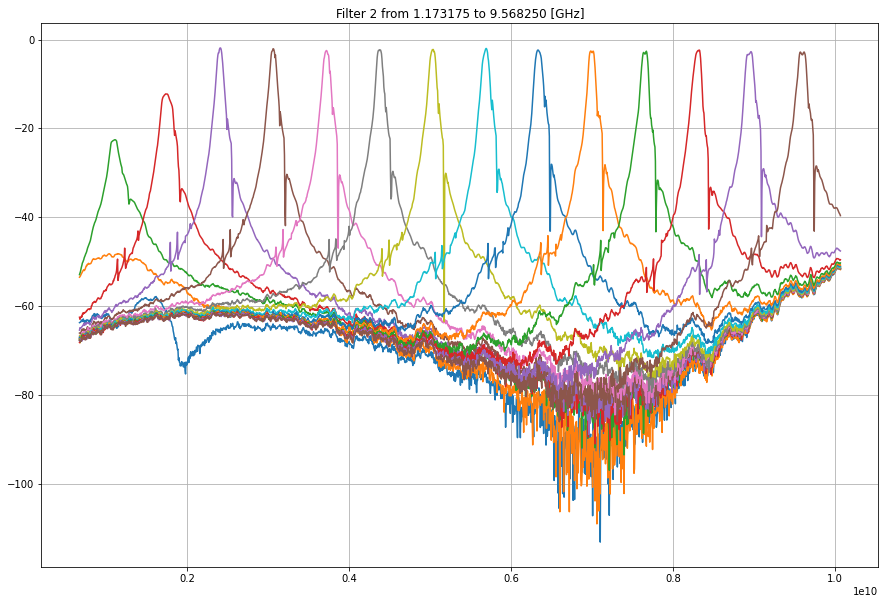

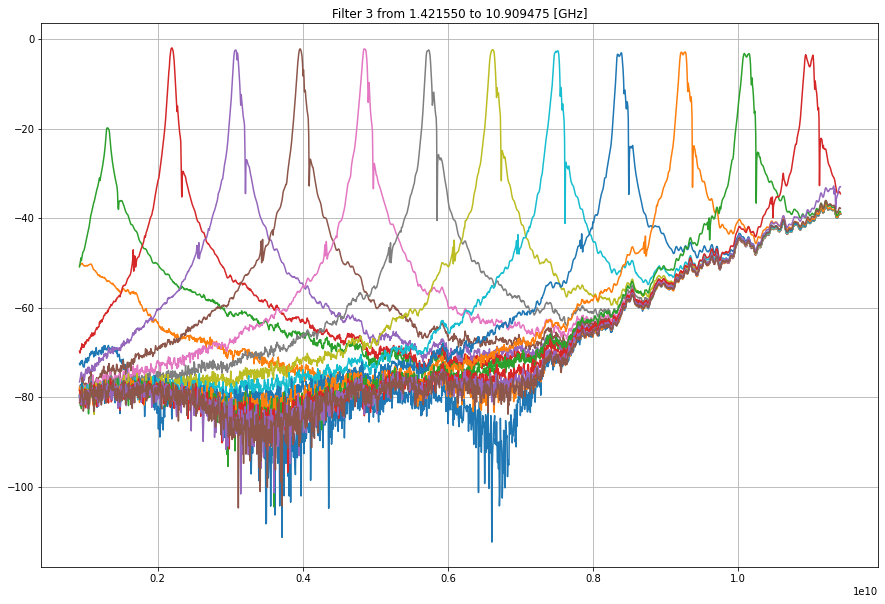

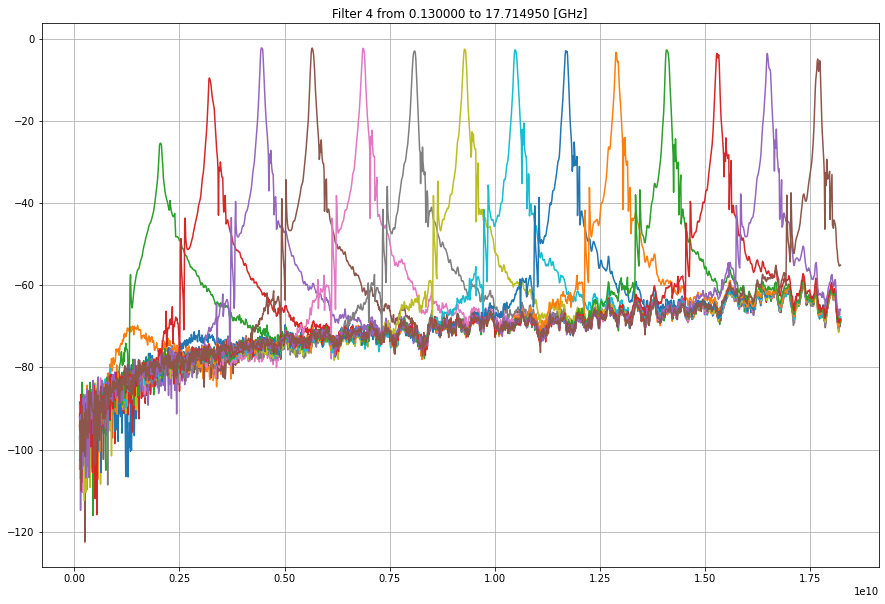

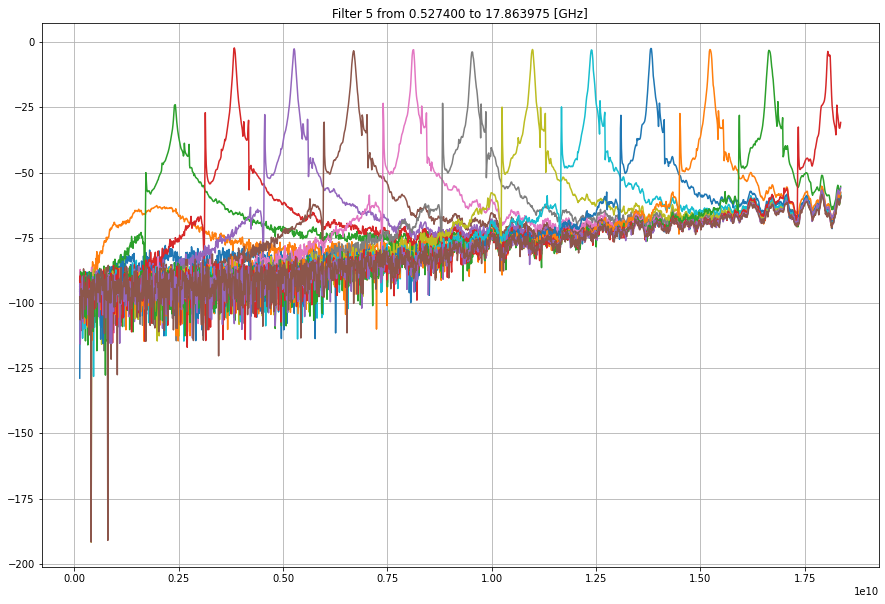

In [10]:
import skrf.network

calPar=skrf.network.Network('cal_through.s2p')
d=loadData('yig_filter_driver_current_data')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

d2=loadData('yig_filter_driver_coarse_frequency')
fRanges=d2['fRanges']
#print(fRanges)
#print(channels)
#print(wr)

def inter(fd, fa, a):
    afd=np.interp(fd, fa, a)
    return afd
    
filterMeas={}
for i in range(len(zeros)):
    switch.set(i+1)
    fsta=fRanges[i,0]-500e6
    fsta=np.max((fsta, 130e6))
    fsto=fRanges[i,1]+500e6
    fsto=np.min((fsto, 20e9))
    vna.setStartFrequency(fsta)
    vna.setStopFrequency(fsto)
    vna.setPoints(1601)
    vwr = np.linspace(fParams[i].lw, fParams[i].hw, 16)
    plt.figure()
    plt.title("Filter %d from %f to %f [GHz]"%(i, fRanges[i,0]/1e9, fRanges[i,1]/1e9))
    thisFilterMeas={}
    thisFilterMeas['words']=[]
    thisFilterMeas['traces']=[]
    thisFilterMeas['frequencies']=[]
    thisFilterMeas['calData']=[]
    for w in vwr:
        yigDriver.set(i, int(w))
        time.sleep(0.5)
        tr = vna.readSParameter('S21')
        fr = vna.frequencies()
        cai=inter(fr, calPar.f, np.abs(calPar.s[:,1,0]))
        #nf, npar = norm(calPar.f, np.abs(calPar.s[:,0,1]), fr, np.abs(tr))
        #plt.plot(nf, npar)
        plt.plot(fr, 20*np.log10(np.abs(tr)/cai))
        thisFilterMeas['words'].append(w)
        thisFilterMeas['traces'].append(tr)
        thisFilterMeas['frequencies'].append(fr)
        thisFilterMeas['calData'].append(cai)
        #plt.plot(fr, cai)
    filterMeas[i] =  thisFilterMeas
    plt.grid(True)
    plt.show()
    yigDriver.set(6, 0)    
    

In [11]:

words = []
frequencies = []
calData = []
traces = []
for i in filterMeas:
    f = filterMeas[i]
    words.append(f['words'])
    frequencies.append(f['frequencies'])
    calData.append(f['calData'])
    traces.append(f['traces'])
    
saveData('coarse_tuning_data', {'words':words, 'frequencies':frequencies, 'calData':calData, 'traces':traces})

In [12]:

kvec=[]
mvec=[]
for i in range(len(zeros)):
    thisFilter=filterMeas[i]
    words = thisFilter['words']
    traces = thisFilter['traces']
    frequencies = thisFilter['frequencies'][0]
    cals = thisFilter['calData']
    fildat=[]
    for trace, w, cal in zip(traces, words, cals):
        tDat = 20*np.log10(np.abs(trace)/np.abs(cal))
        i=np.argmax(tDat)
        if(tDat[i]>-5):
            fildat.append((int(w), frequencies[i]/1e6, tDat[i]))

    j=int(len(fildat)/5.0)
    jj=int(4*len(fildat)/5.0)
    m=int((j+jj)/2)
    dw=fildat[jj][0]-fildat[j][0]
    df=fildat[jj][1]-fildat[j][1]
    filK=df/dw
    ms=[]
    for m in range(len(fildat)):
        filM=fildat[m][1]-fildat[m][0]*filK
        ms.append(filM)
    filM=np.mean(ms)
    print("Filter parameter for filter %d is k %.3f [MHz/LSB] m is %.3f[LSB]"%(i, filK, filM))
    kvec.append(filK)
    mvec.append(filM)

coarseFilter={'k':kvec, 'm':mvec}
saveData('coarse_filter_parameters', coarseFilter)
        

Filter parameter for filter 1178 is k 0.025 [MHz/LSB] m is 695.861[LSB]
Filter parameter for filter 1417 is k 0.072 [MHz/LSB] m is 1988.680[LSB]
Filter parameter for filter 1524 is k 0.167 [MHz/LSB] m is 4526.771[LSB]
Filter parameter for filter 1569 is k 0.330 [MHz/LSB] m is 8954.646[LSB]
Filter parameter for filter 1552 is k 0.305 [MHz/LSB] m is 8348.872[LSB]
Filter parameter for filter 1560 is k 0.361 [MHz/LSB] m is 9869.574[LSB]


## Measure drift

In [13]:
import time
coarseFilter=loadData('coarse_filter_parameters')
mvec=coarseFilter['m'][0]
kvec=coarseFilter['k'][0]


def computeWord(fTarget, k, m):
    return (fTarget/1e6-m)/k

s21Drift=None
currentDrift=None

dataDict={}

def measureDrifts():
    for a in range(3):
        curMeter.readValue()
    t0=time.time()
    t00=t0
    fmax=[]
    curr=[]
    phase=[]
    sFreq = None
    sMat = None
    timeVec = []
    for j in range(10):
        t0=t00+10*j
        while time.time() < t0:
            pass
        f=vna.frequencies()
        curr.append(curMeter.readValue())
        t=vna.readSParameter('S21')
        fmax.append(f[np.argmax(np.abs(t))])
        phase.append(np.angle(t[int(len(t)/2)]))
        sFreq = f;
        sMat = yig_controller_test.stackVector(sMat, t)
        timeVec.append(t0)
    return timeVec, f, curr, phase, sMat, fmax
    

for i in range(6):
    print("Measuring filter", i)
    k = kvec[i]
    m = mvec[i]
    switch.set(i+1)
    keyBase = 'yigFilter%d'%(i)
    for tf, keySub in zip([fMin[i], fMax[i], fMin[i]], ['Low', 'High', 'LowAgain']):
        yigDriver.set(i, int(computeWord(tf, k, m)))
        vna.setStartFrequency(tf-100e6)
        vna.setStopFrequency(tf+100e6) 
        timeVec, f, curr, phase, sMat, fmax = measureDrifts()
        dataDict[keyBase+keySub+'Current']=curr 
        dataDict[keyBase+keySub+'Time']=timeVec
        dataDict[keyBase+keySub+'Frequency']=f
        dataDict[keyBase+keySub+'Phase']=phase
        dataDict[keyBase+keySub+'SMatrix']=sMat
        dataDict[keyBase+keySub+'MinimumLossFrequency']=fmax
        
        
saveData('filter_drift', dataDict)

Measuring filter 0
Measuring filter 1
Measuring filter 2
Measuring filter 3
Measuring filter 4
Measuring filter 5


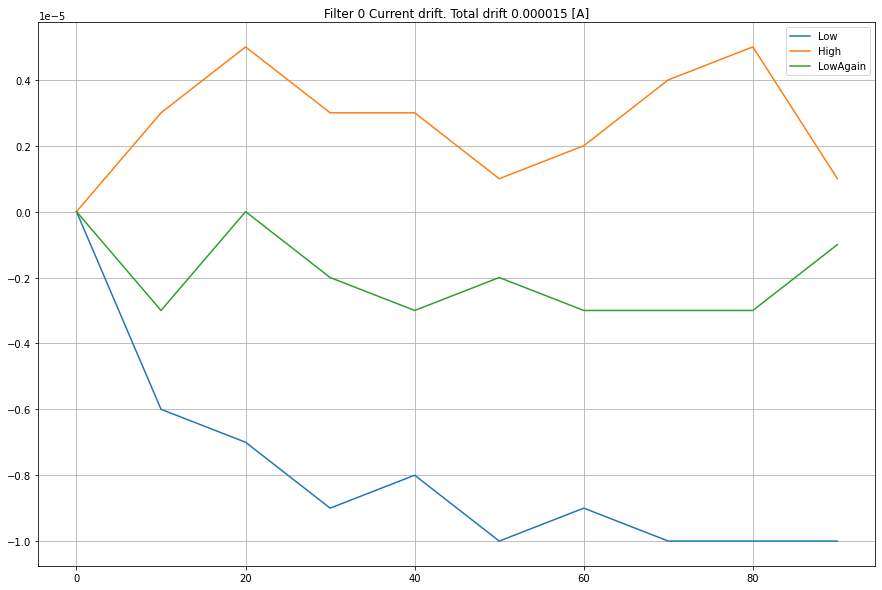

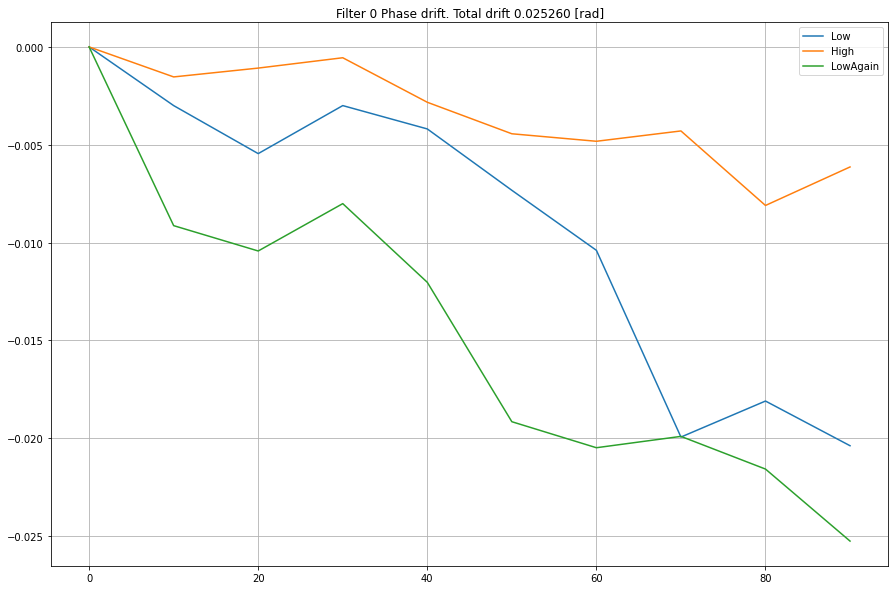

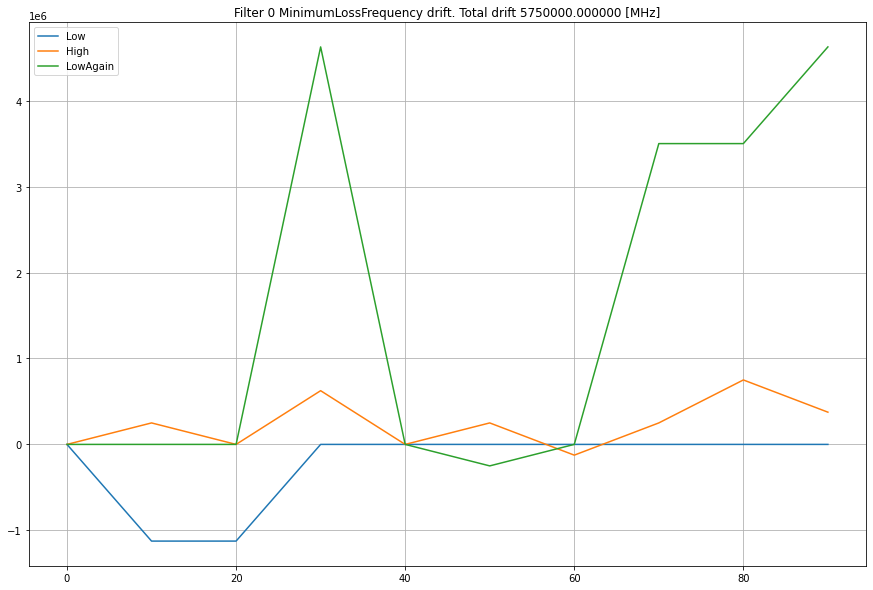

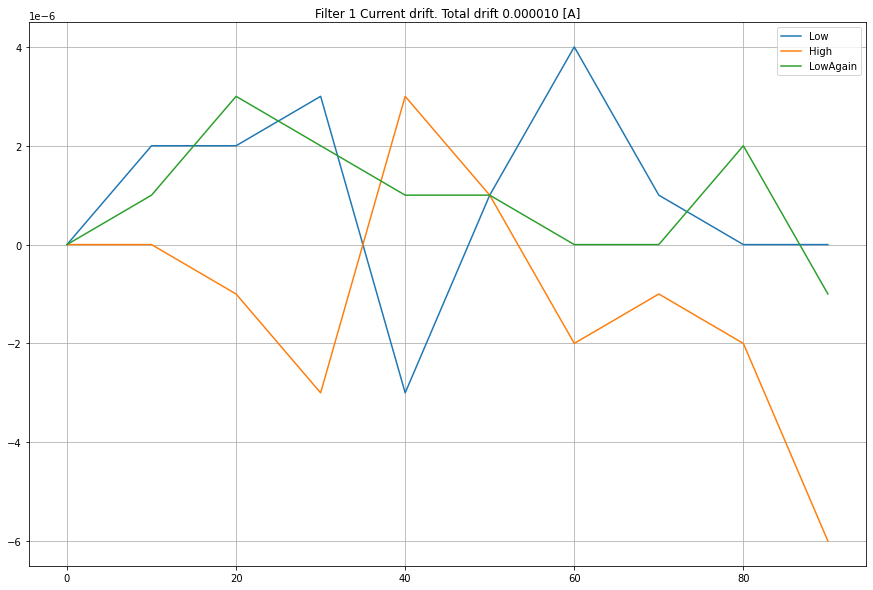

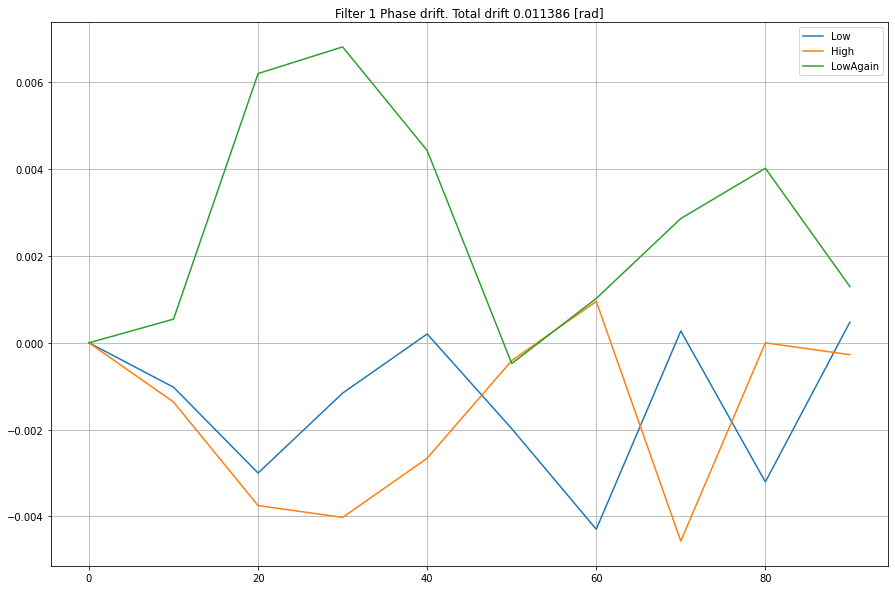

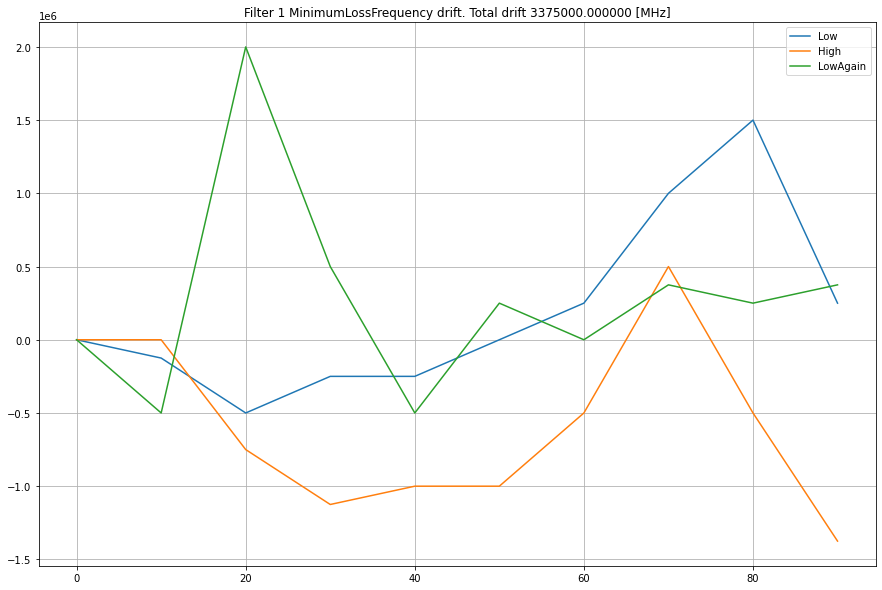

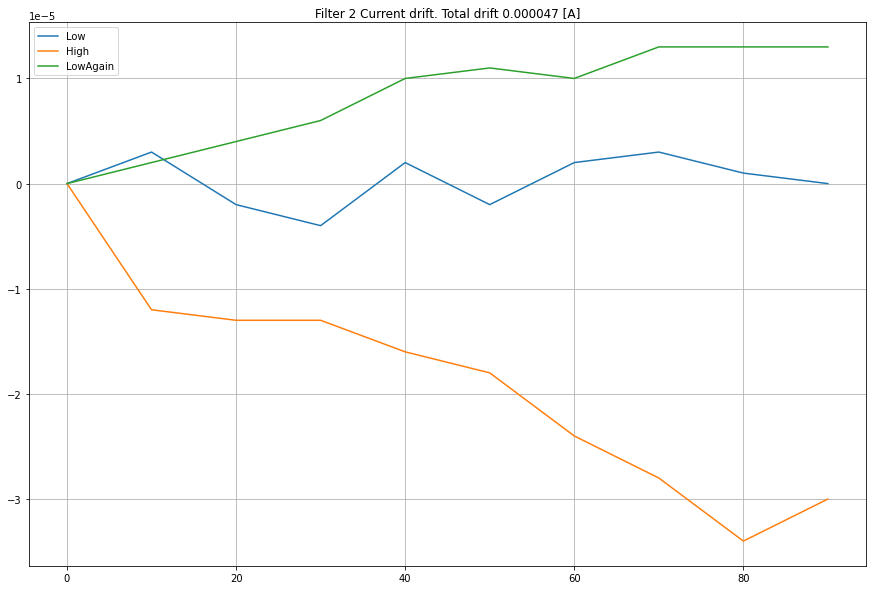

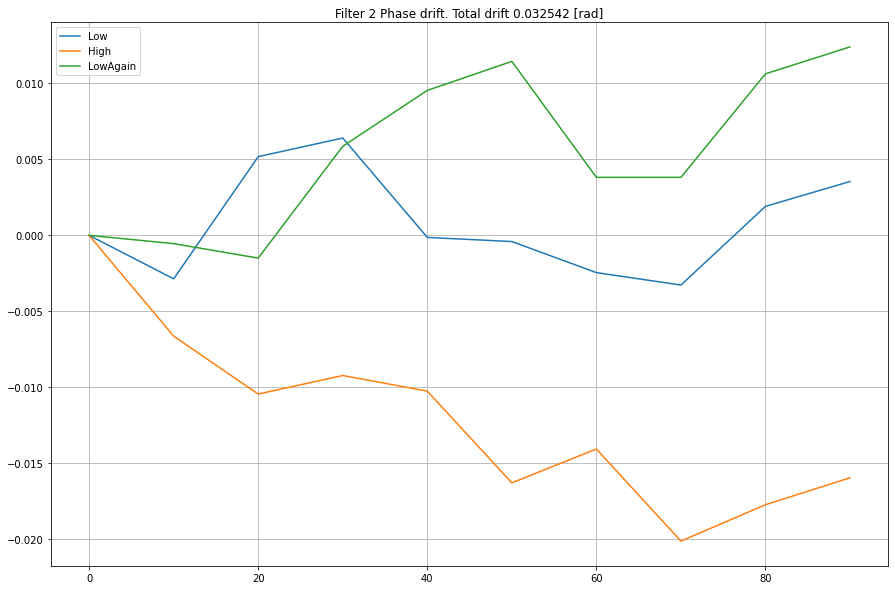

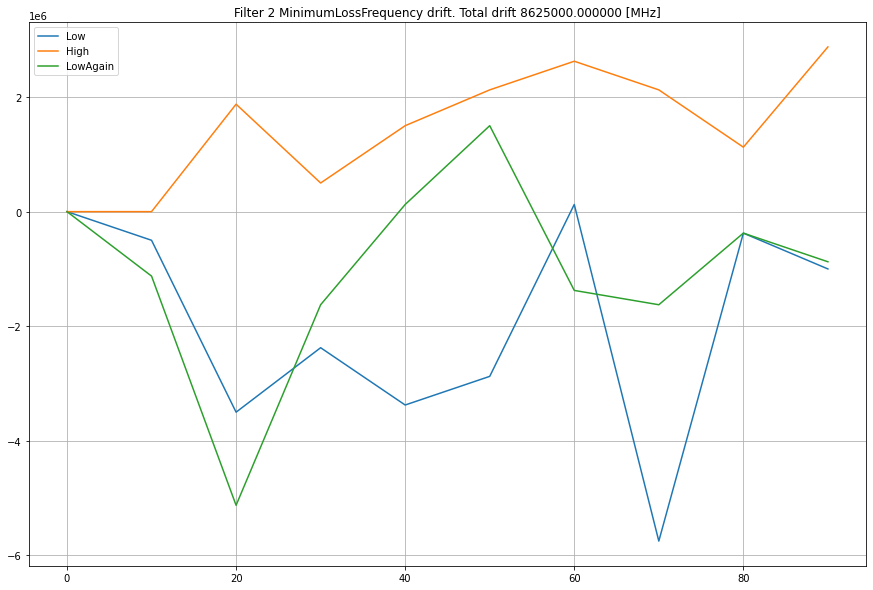

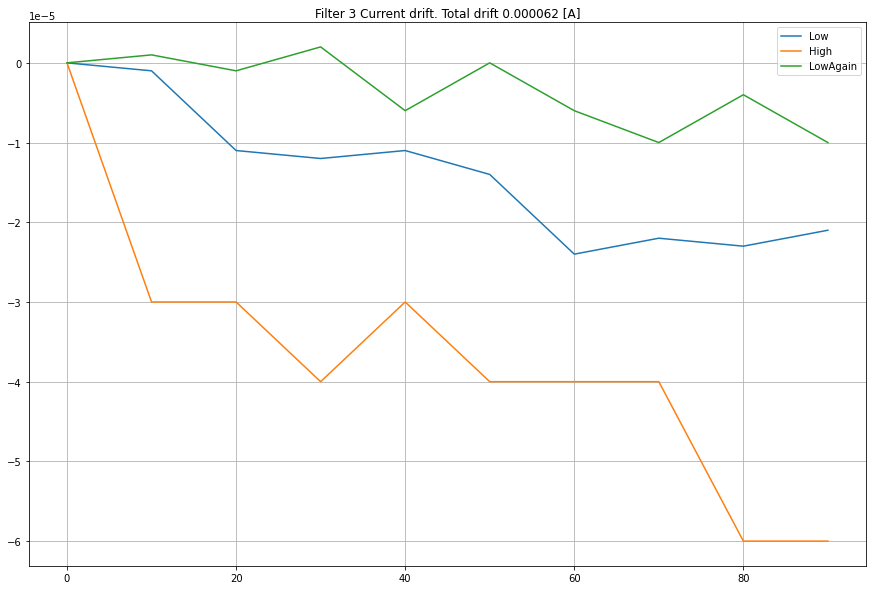

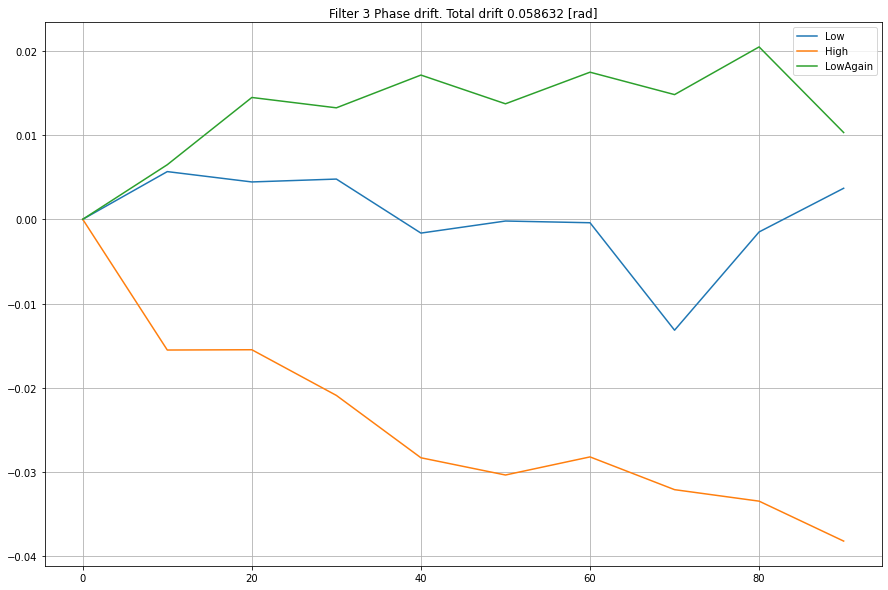

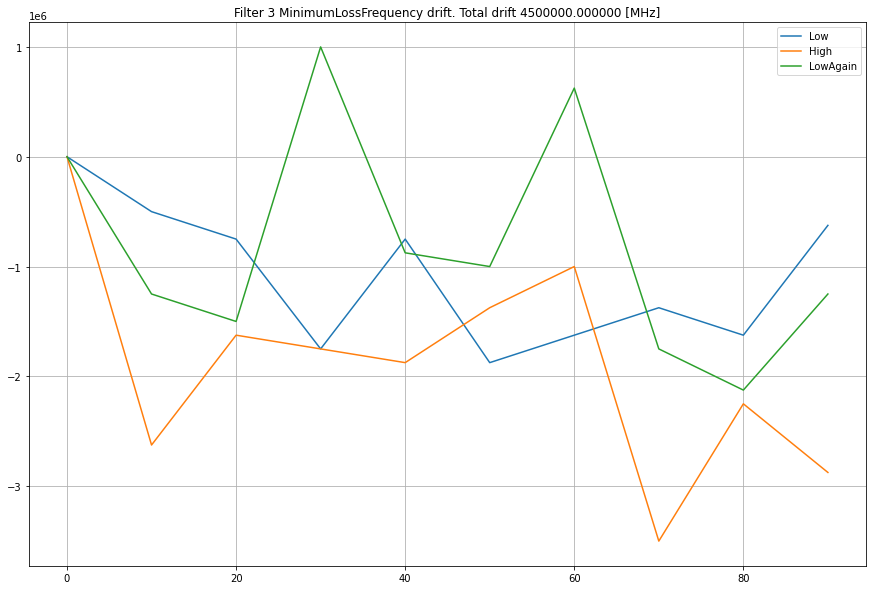

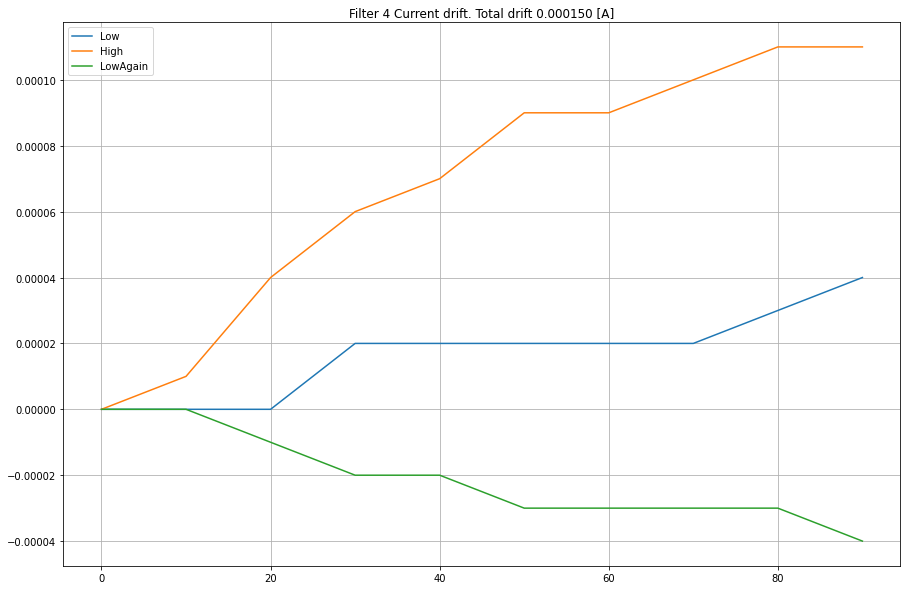

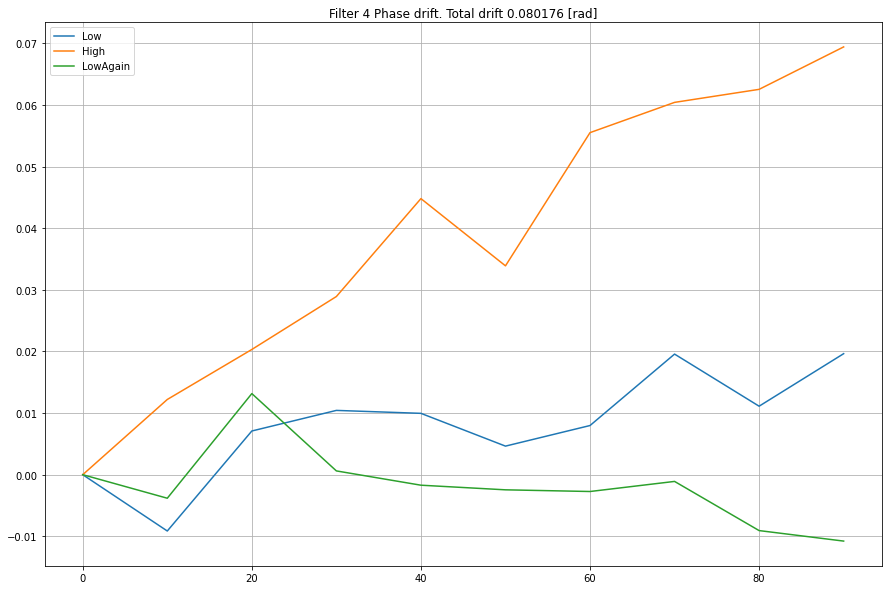

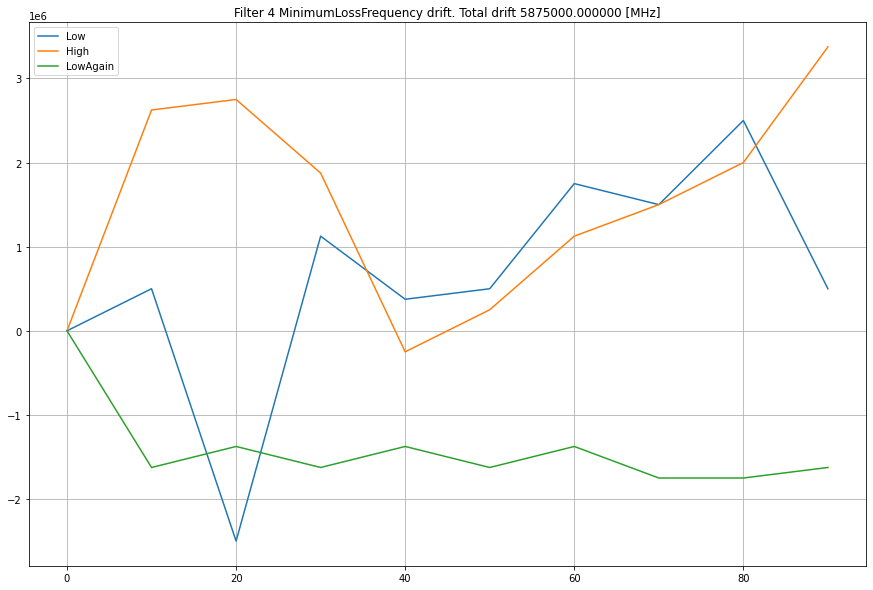

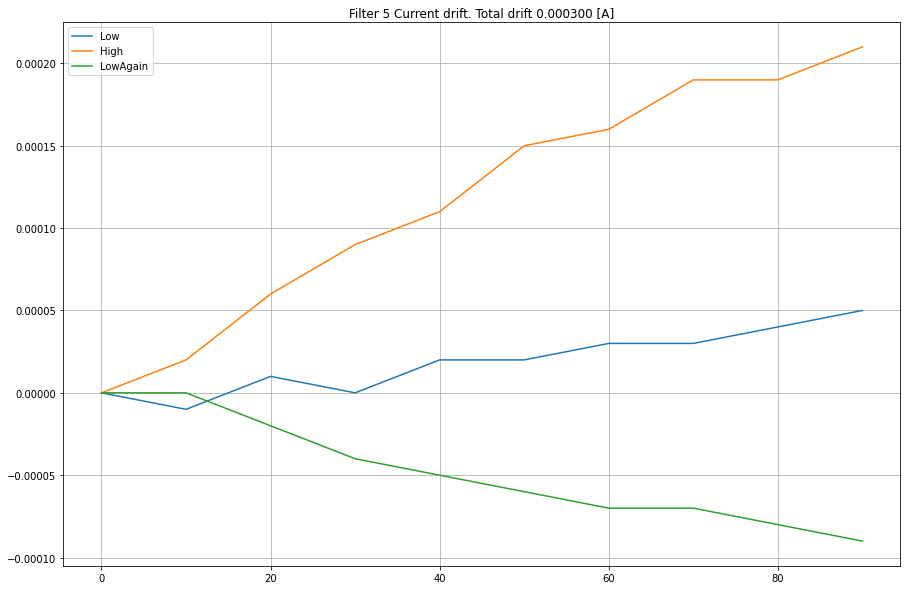

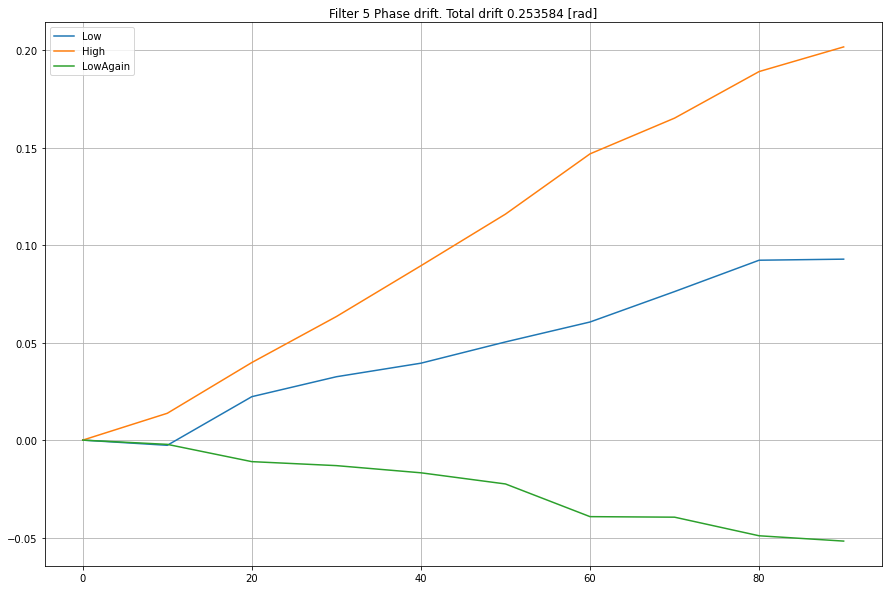

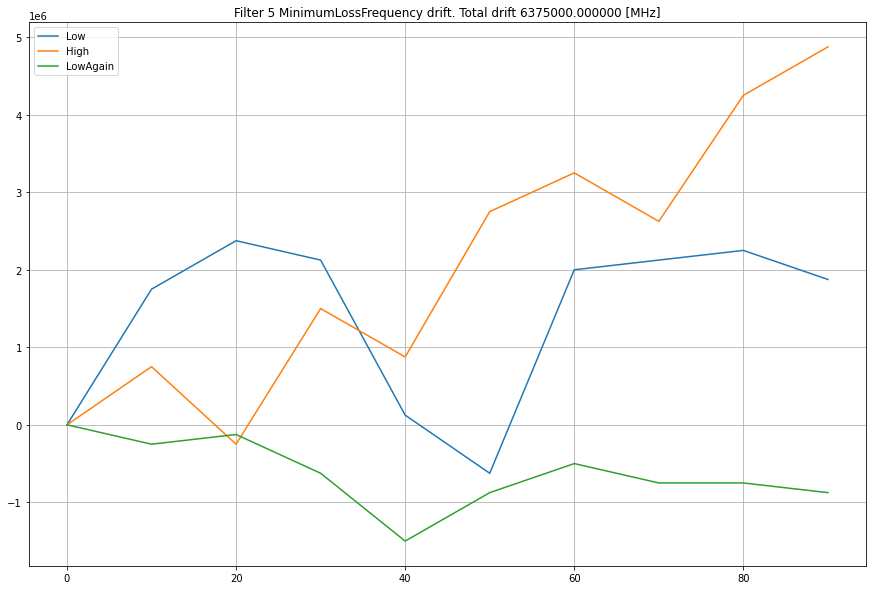

In [14]:
dd = loadData('filter_drift')

def plotParameter(i, par, unit):
    keyBase = 'yigFilter%d'%(i)
    plt.figure()
    
    minVal=None
    maxVal=None
    for keySub in ['Low', 'High', 'LowAgain']:
        data=dd[keyBase+keySub+par][0]
        timeData=dd[keyBase+keySub+'Time'][0]
        timeData=timeData-timeData[0]
        data=data-data[0]
        plt.plot(timeData, data, label=keySub)
        if minVal is None:
            minVal=min(data)
        else:
            minVal = min(minVal, min(data))
        if maxVal is None:
            maxVal=max(data)
        else:
            maxVal=max(maxVal, max(data))
        
    plt.title("Filter %d %s drift. Total drift %f [%s]"%(i, par, maxVal-minVal, unit))    
    plt.grid(True)
    plt.legend()
    plt.show()

for i in range(6):
    plotParameter(i, 'Current', 'A')
    plotParameter(i, 'Phase', 'rad')
    plotParameter(i, 'MinimumLossFrequency', 'MHz')
        
        
    

## Fine tuning of filter tuning parameters

In [15]:
a = loadData('coarse_filter_parameters')
import yig_controller_test
import yig_filter_model

ks = a['k'][0]
ms = a['m'][0]
filterBank = []
for i in range(len(ks)):
    filterBank.append(yig_controller_test.YigFilter(fMin[i], fMax[i], ms[i]*1e6, ks[i]*1e6, yc, i))
    
calMeas = skrf.network.Network('cal_through.s2p')

fix = yig_filter_model.SimpleS21Fixture(calMeas.f, calMeas.s[:, 1, 0])

yc.yigB.set(0,0)
yc.yigA.set(6,0)
yc.yigB.set(7,0)

def measureYigFilter(f):
    frequencies = np.linspace(f.flow, f.fhigh, 101)
    vna.setPoints(201)
    filterMap=None
    spanMap=None
    tuningWords=[]
    for fr in frequencies:
        f.tuneTo(fr, channel=yigDriver)
        tuningWords.append(f.computetTuningWord(fr))
        vna.setStartFrequency(fr-250e6)
        vna.setStopFrequency(fr+250e6)
        spar=vna.readSParameter('S21')
        fax = vna.frequencies()
        spanMap = yig_controller_test.stackVector(spanMap, fax)
        dePar=fix.deembedFrom(fax, spar)
        filterMap=yig_controller_test.stackVector(filterMap, dePar)
    plt.figure()
    plt.imshow(20*np.log10(np.abs(filterMap)))
    plt.colorbar()
    plt.show()
    return filterMap, tuningWords, frequencies, spanMap
        
                             
                             
    

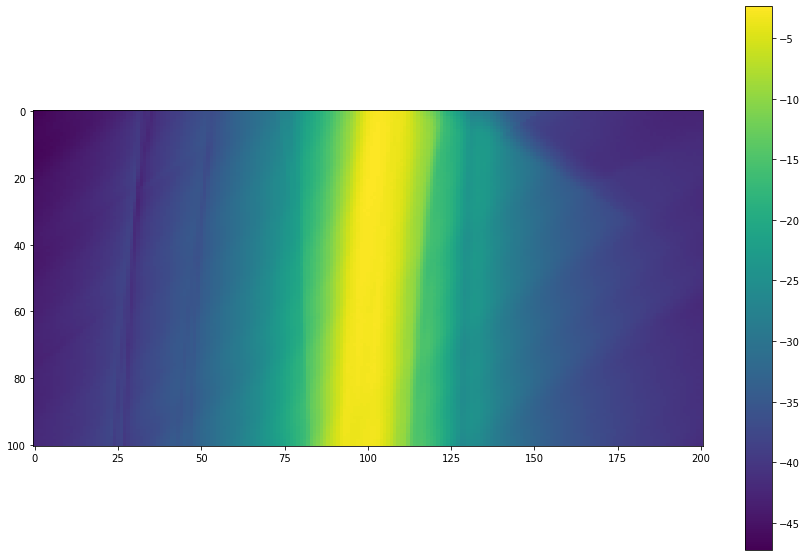

In [16]:
filter0Map, filter0TuningWords, filter0Frequencies, filter0SpanMap = measureYigFilter(filterBank[0])

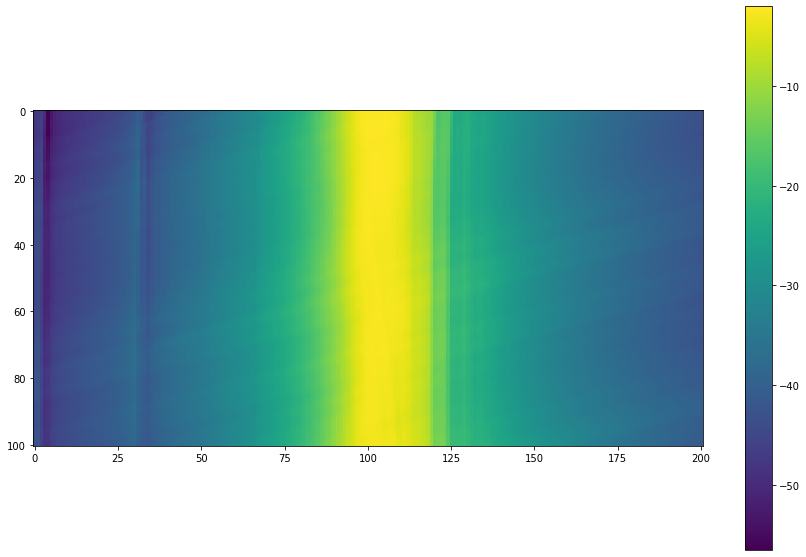

In [17]:
filter1Map, filter1TuningWords, filter1Frequencies, filter1SpanMap = measureYigFilter(filterBank[1])

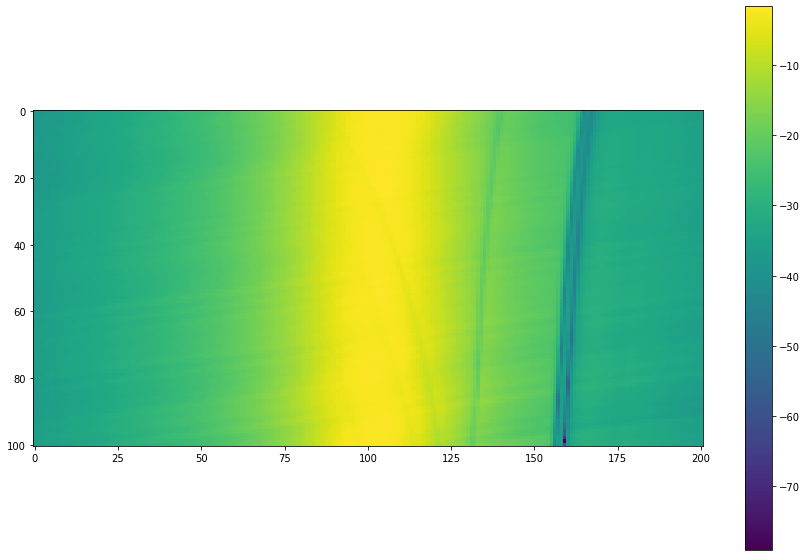

In [18]:
filter2Map, filter2TuningWords, filter2Frequencies, filter2SpanMap = measureYigFilter(filterBank[2])

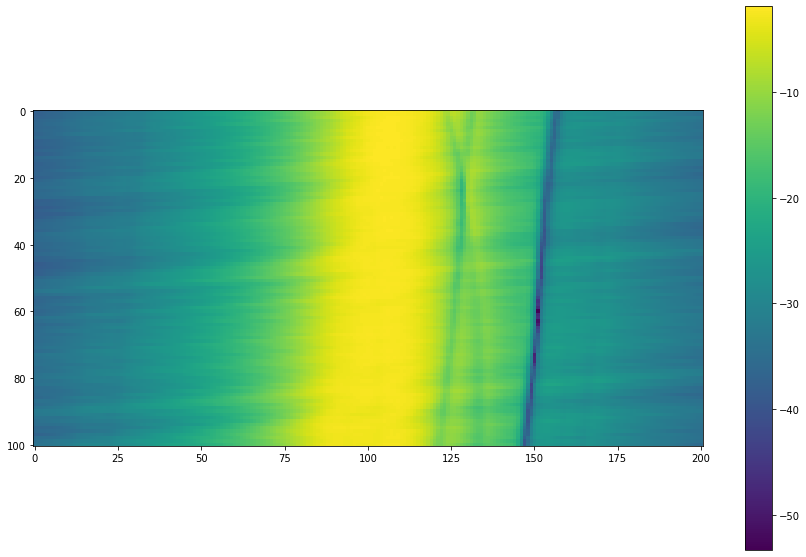

In [19]:
filter3Map, filter3TuningWords, filter3Frequencies, filter3SpanMap = measureYigFilter(filterBank[3])

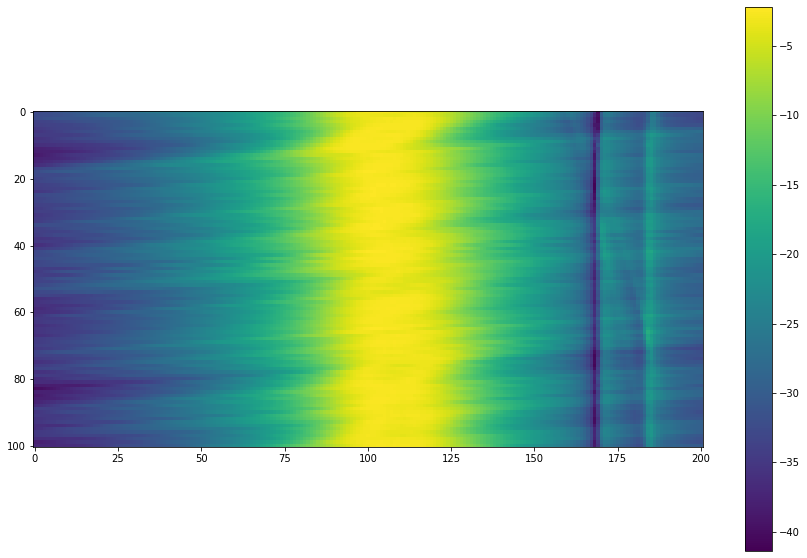

In [20]:
filter4Map, filter4TuningWords, filter4Frequencies, filter4SpanMap = measureYigFilter(filterBank[4])

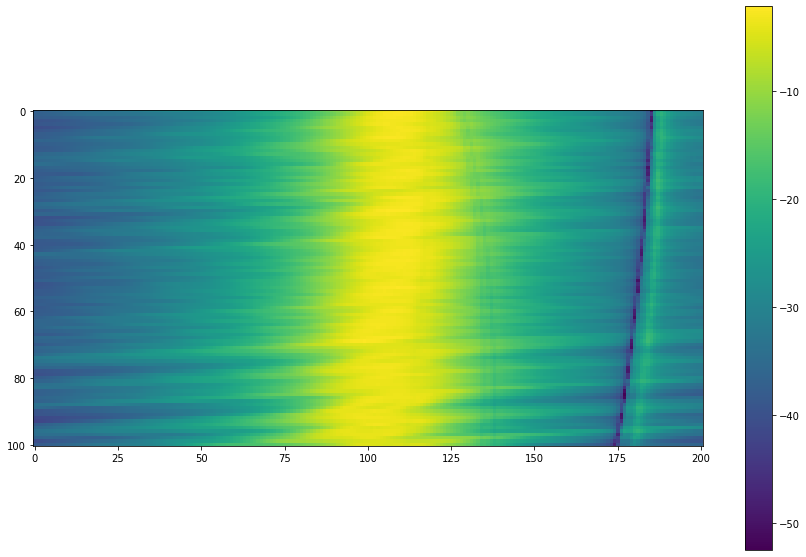

In [22]:
filter5Map, filter5TuningWords, filter5Frequencies, filter5SpanMap = measureYigFilter(filterBank[5])

In [23]:
saveDict={'filter0Map':filter0Map, 'filter0TuningWords':filter0TuningWords, 'filter0Frequencies':filter0Frequencies, 'filter0SpanMap':filter0SpanMap, 
          'filter1Map':filter1Map, 'filter1TuningWords':filter1TuningWords, 'filter1Frequencies':filter1Frequencies, 'filter1SpanMap':filter1SpanMap, 
          'filter2Map':filter2Map, 'filter2TuningWords':filter2TuningWords, 'filter2Frequencies':filter2Frequencies, 'filter2SpanMap':filter2SpanMap, 
          'filter3Map':filter3Map, 'filter3TuningWords':filter3TuningWords, 'filter3Frequencies':filter3Frequencies, 'filter3SpanMap':filter3SpanMap, 
          'filter4Map':filter4Map, 'filter4TuningWords':filter4TuningWords, 'filter4Frequencies':filter4Frequencies, 'filter4SpanMap':filter4SpanMap, 
          'filter5Map':filter5Map, 'filter5TuningWords':filter5TuningWords, 'filter5Frequencies':filter5Frequencies, 'filter5SpanMap':filter5SpanMap, }
saveData('coarse_tuning_fine_measurements', saveDict)

In [24]:


def dB(data):
    return 20*np.log10(np.abs(data))

def fineTuneAnalysis(meas, i):
    baseKey='filter%d'%(i)
    filterMap = meas[baseKey+'Map']
    tuningWords = meas[baseKey+'TuningWords'][0]
    frequencies = meas[baseKey+'Frequencies'][0]
    spanMap = meas[baseKey+'SpanMap']
    dBFilt=dB(filterMap)
    peaksIdx=np.argmax(dB(filterMap),axis=1)
    peaksVal=np.max(dB(filterMap),axis=1)
    
    x = np.arange(peaksIdx.shape[0])
    bestLineCoeff=np.polyfit(x, peaksIdx-100, deg=1)
    k, m =bestLineCoeff
    
    span=spanMap[0]
    deltaF=(max(span)-min(span))/float(len(span)-1)
    deltaW =(max(tuningWords)-min(tuningWords))/float(len(tuningWords)-1)
    
    kcorr=k*(deltaF/1e6)*(1/deltaW)
    mcorr=m*deltaF/1e6
    lineFunc=np.poly1d(bestLineCoeff)
    
   
    filterNorm = (dBFilt.T-peaksVal).T;
    plt.figure();
    plt.title("Filter %d"%(i))
    
    plt.imshow(filterNorm)
    
    yr = np.array(range(filterMap.shape[0]))
    
    
    plt.plot(peaksIdx, yr)
    peaksIdxFilter=np.convolve(peaksIdx, np.ones((10,))/10, mode='same')
   
    plt.plot(peaksIdxFilter, yr)
    plt.plot(lineFunc(x)+100,x)
    plt.contour(filterNorm, [-10, -6, -3])
    plt.figure()
    plt.title("Filter %d"%(i))
    plt.plot(np.arange(10,91), peaksIdxFilter[10:-10]-100)
    plt.plot(peaksIdx-100)
    plt.grid(True)
    
   
   
    plt.plot(x, lineFunc(x))
    return kcorr, mcorr
    #plt.contourf(db(filterMap), []
  


filter 0 Coarse k 0.02459257264740666 [MHZ/lsb] coarse m 695.8610767484888 [MHz]
filter 0 fine   k 0.0241218523454352 [MHZ/lsb] cfine  m 700.3325386005564 [MHz]
filter 1 Coarse k 0.07198375827578563 [MHZ/lsb] coarse m 1988.6798137180665 [MHz]
filter 1 fine   k 0.07196908374452055 [MHZ/lsb] cfine  m 1993.16292379378 [MHz]
filter 2 Coarse k 0.1666637734414597 [MHZ/lsb] coarse m 4526.770553316782 [MHz]
filter 2 fine   k 0.16606777266491143 [MHZ/lsb] cfine  m 4540.321805500824 [MHz]
filter 3 Coarse k 0.33048126672787254 [MHZ/lsb] coarse m 8954.646352874293 [MHz]
filter 3 fine   k 0.33045817044833675 [MHZ/lsb] cfine  m 8968.003953340221 [MHz]
filter 4 Coarse k 0.30458581738891705 [MHZ/lsb] coarse m 8348.872258939577 [MHz]
filter 4 fine   k 0.30481777066971216 [MHZ/lsb] cfine  m 8359.10667944045 [MHz]
filter 5 Coarse k 0.360524562716464 [MHZ/lsb] coarse m 9869.57386231592 [MHz]
filter 5 fine   k 0.3589626704519638 [MHZ/lsb] cfine  m 9900.515912403282 [MHz]


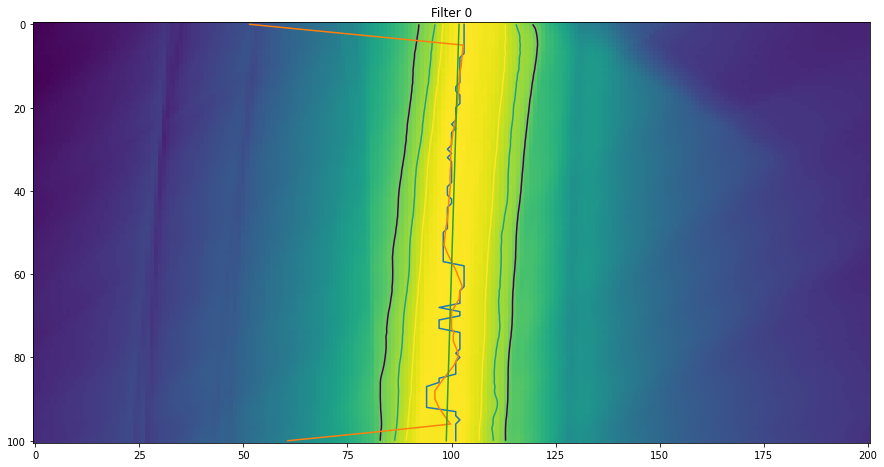

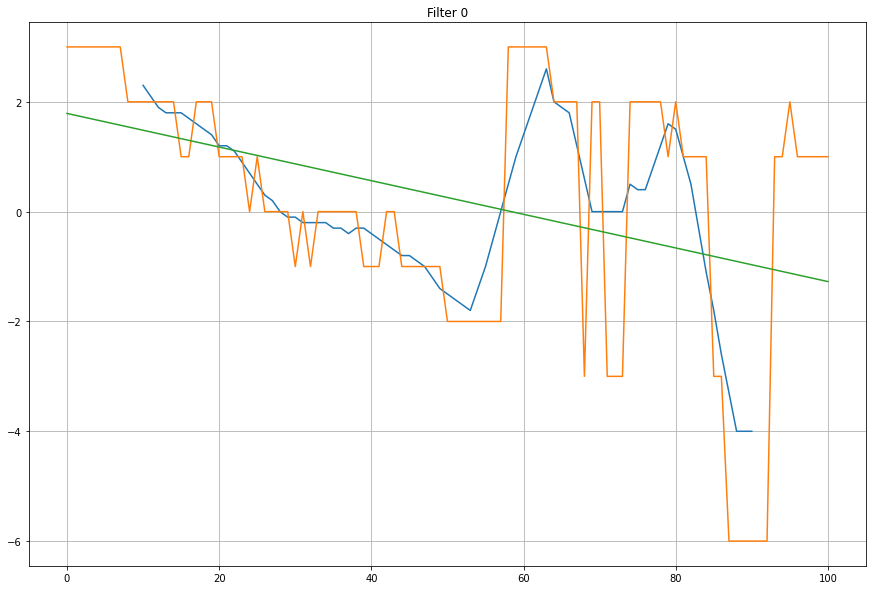

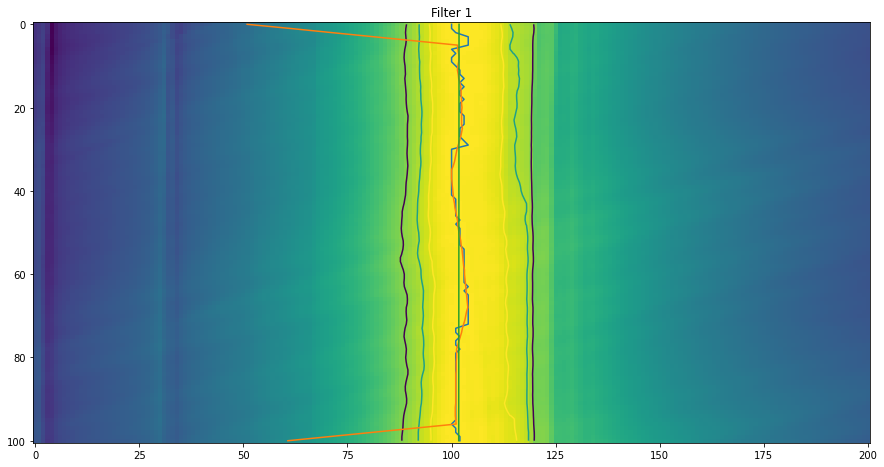

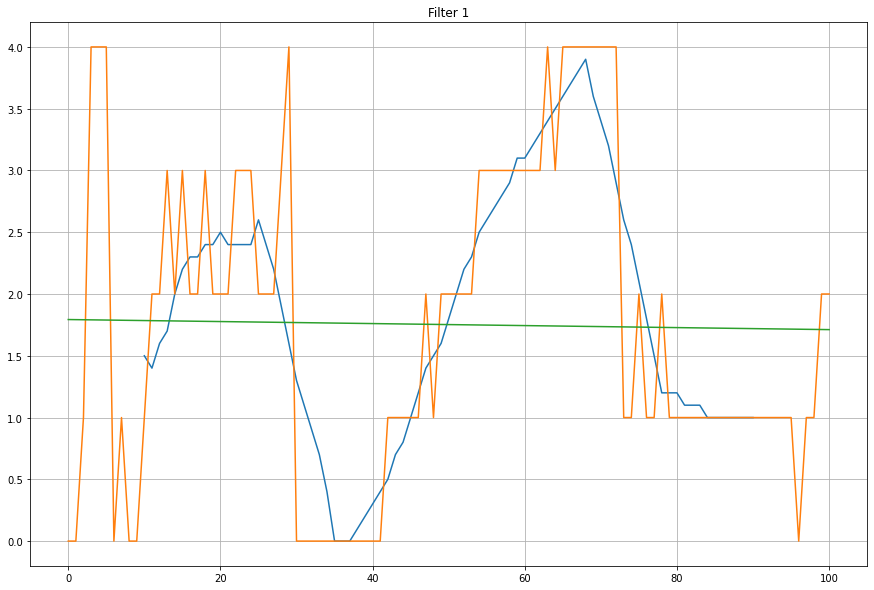

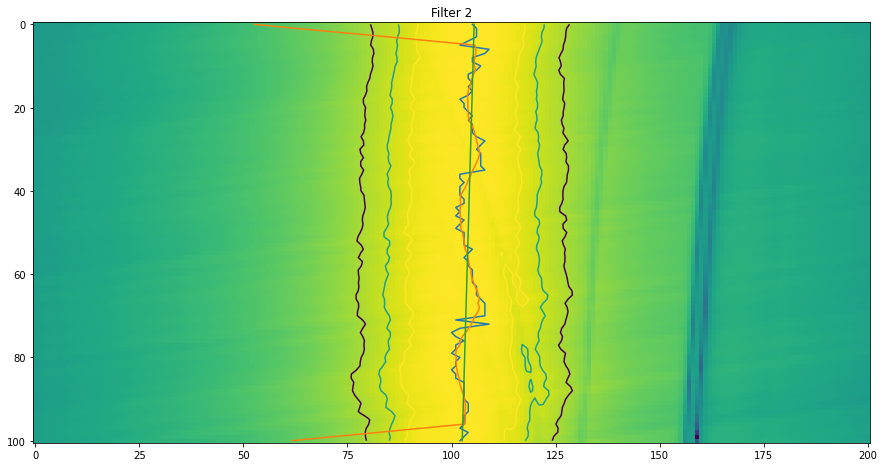

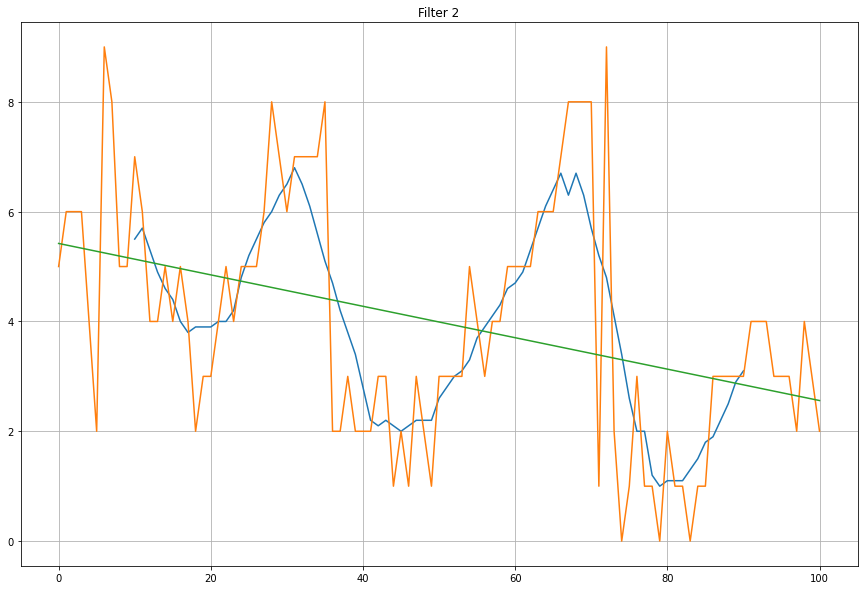

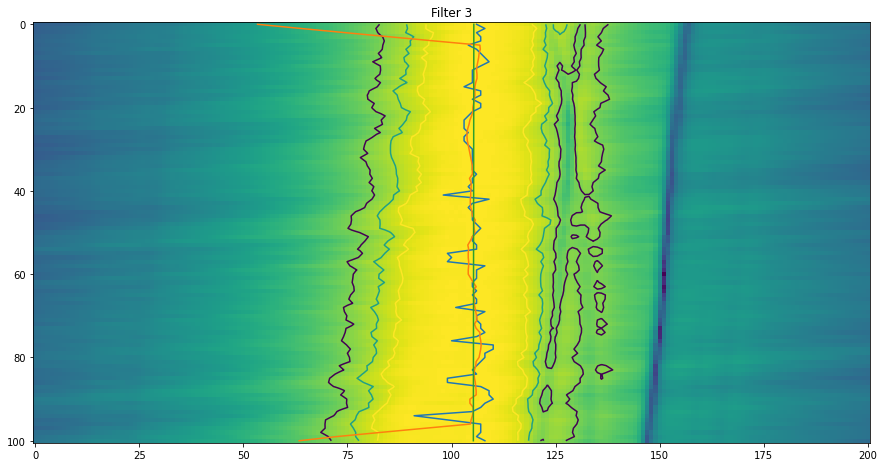

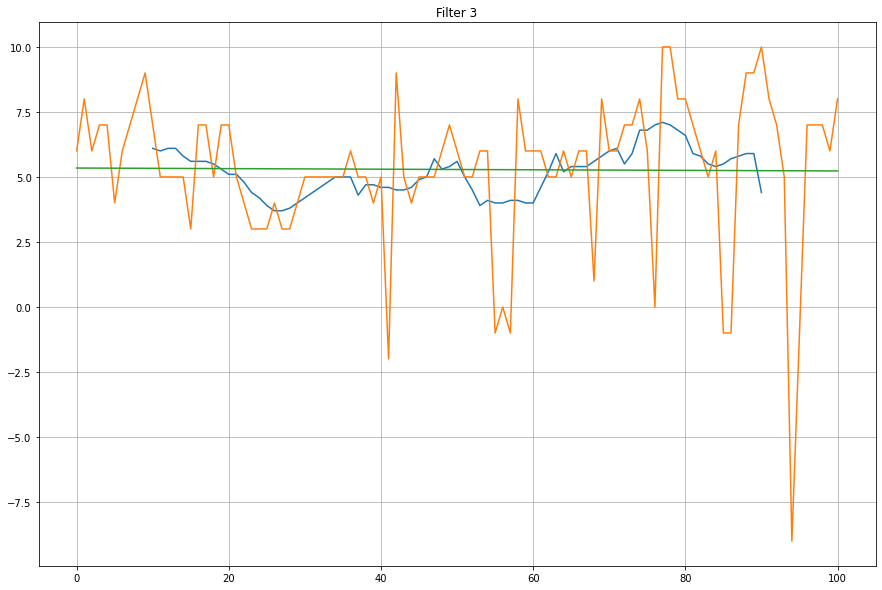

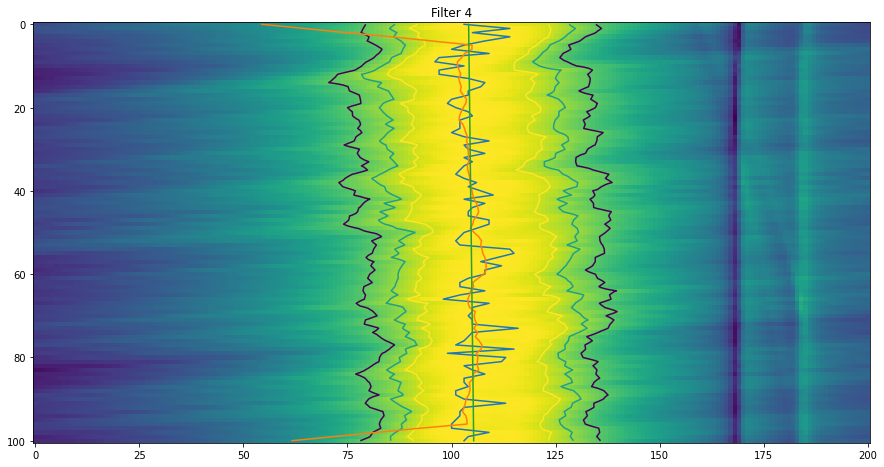

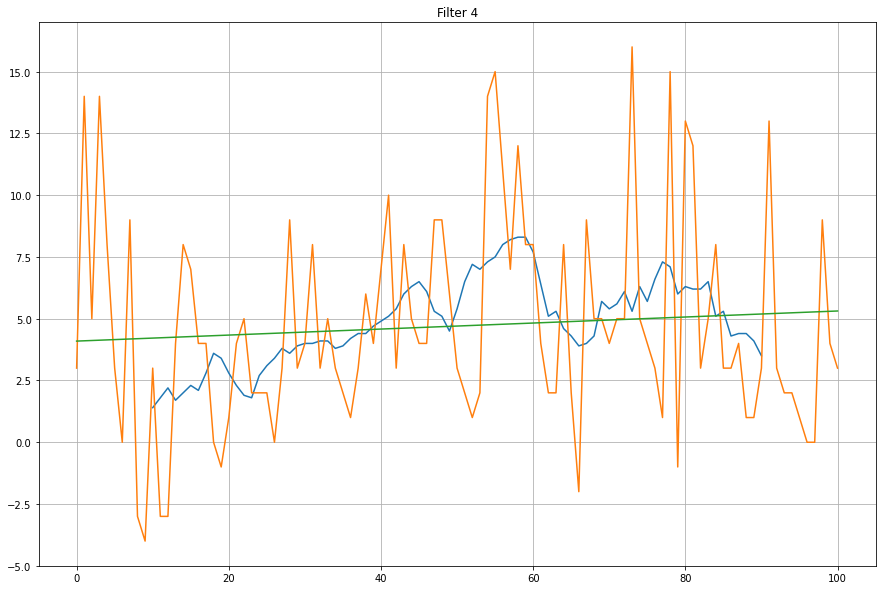

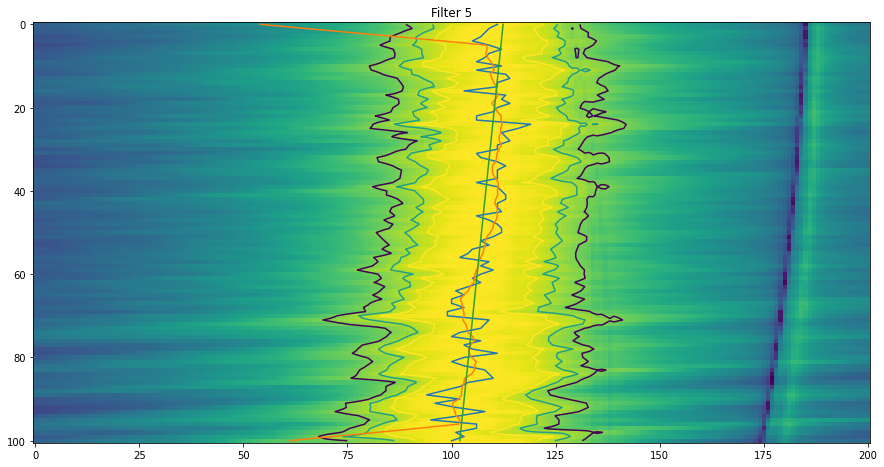

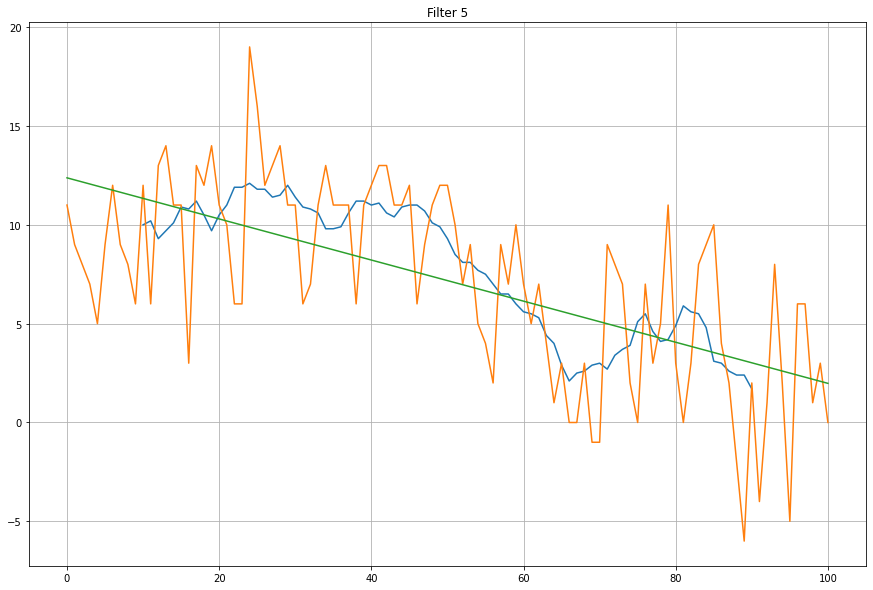

In [25]:
ftm = loadData('coarse_tuning_fine_measurements')
coarseData = loadData('coarse_filter_parameters')

kcoarse = coarseData['k'][0]
mcoarse = coarseData['m'][0]    
kfine = kcoarse
mfine = mcoarse

for i in range(6):
    k, m = fineTuneAnalysis(ftm, i)
    print("filter",i,"Coarse k", kcoarse[i], "[MHZ/lsb]", "coarse m", mcoarse[i], "[MHz]")
    kfine[i] = kcoarse[i] + k
    mfine[i] = mcoarse[i] + m
    print("filter",i,"fine   k", kfine[i], "[MHZ/lsb]", "cfine  m", mfine[i], "[MHz]")
fineTuned={'k':kfine, 'm':mfine}
saveData('fine_filter_parameters', fineTuned)

dict_keys(['__header__', '__version__', '__globals__', 'filter0Map', 'filter0TuningWords', 'filter0Frequencies', 'filter0SpanMap', 'filter1Map', 'filter1TuningWords', 'filter1Frequencies', 'filter1SpanMap', 'filter2Map', 'filter2TuningWords', 'filter2Frequencies', 'filter2SpanMap', 'filter3Map', 'filter3TuningWords', 'filter3Frequencies', 'filter3SpanMap', 'filter4Map', 'filter4TuningWords', 'filter4Frequencies', 'filter4SpanMap', 'filter5Map', 'filter5TuningWords', 'filter5Frequencies', 'filter5SpanMap', 'hardwareDescription'])
K 42.726854 [LSB/MHz] M -30092.689925 [LSB]
K 13.834381 [LSB/MHz] M -27678.943489 [LSB]
K 6.014518 [LSB/MHz] M -27246.013514 [LSB]
K 3.040669 [LSB/MHz] M -27210.554325 [LSB]
K 3.274538 [LSB/MHz] M -27379.186811 [LSB]
K 2.783653 [LSB/MHz] M -27577.347908 [LSB]


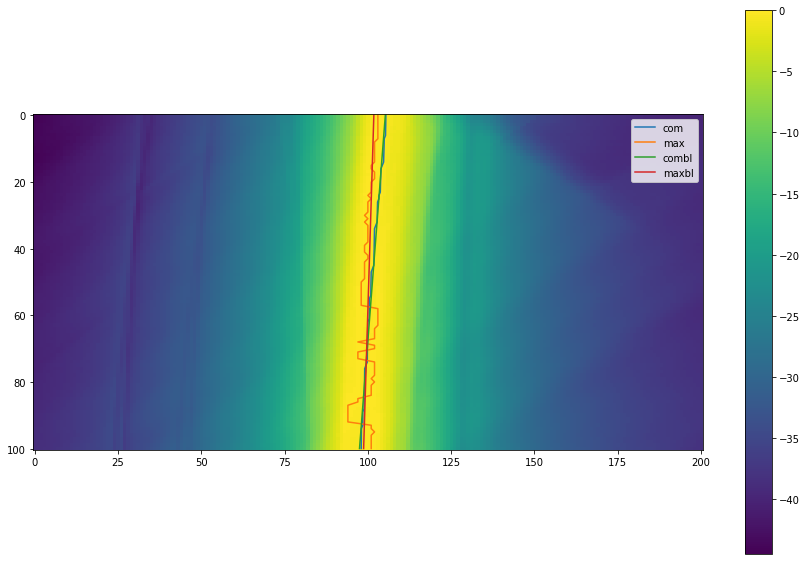

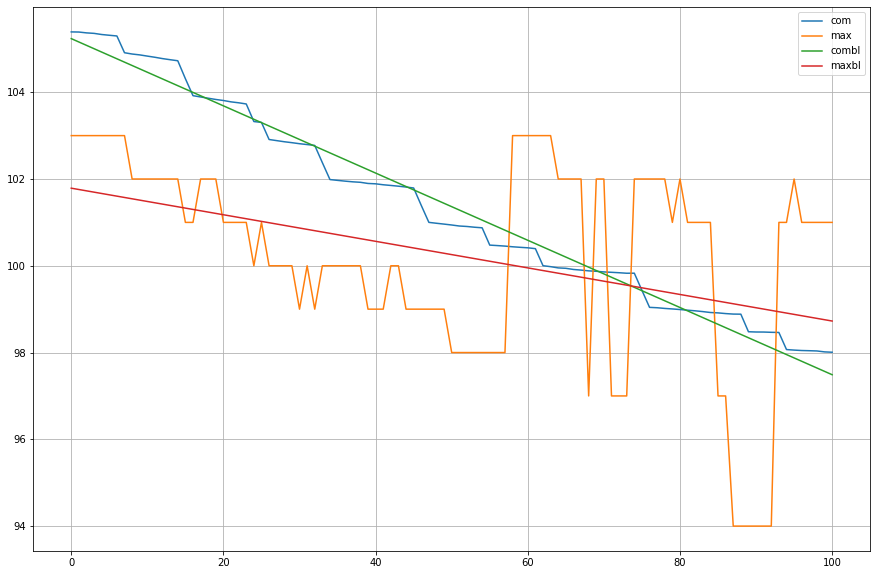

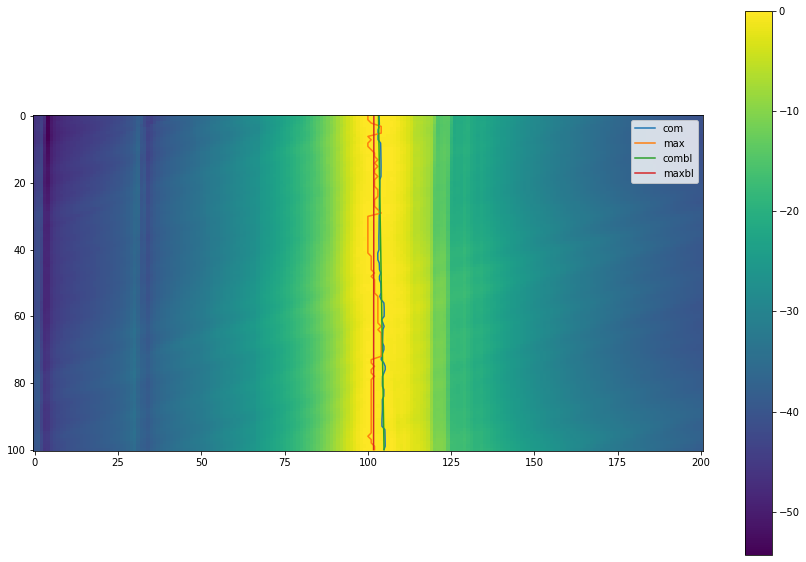

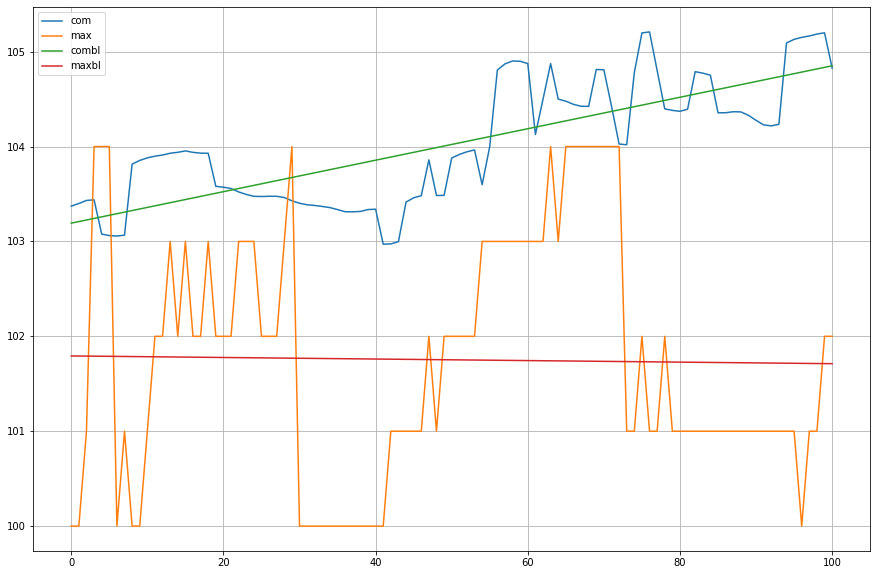

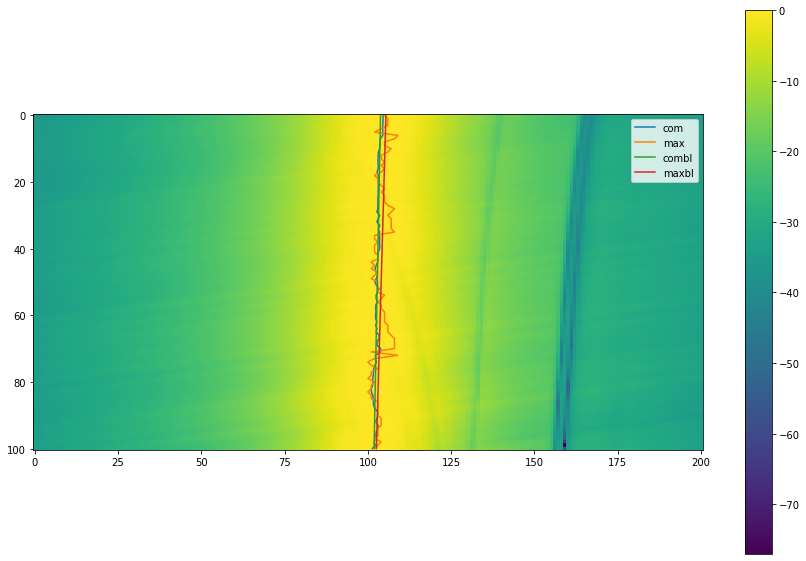

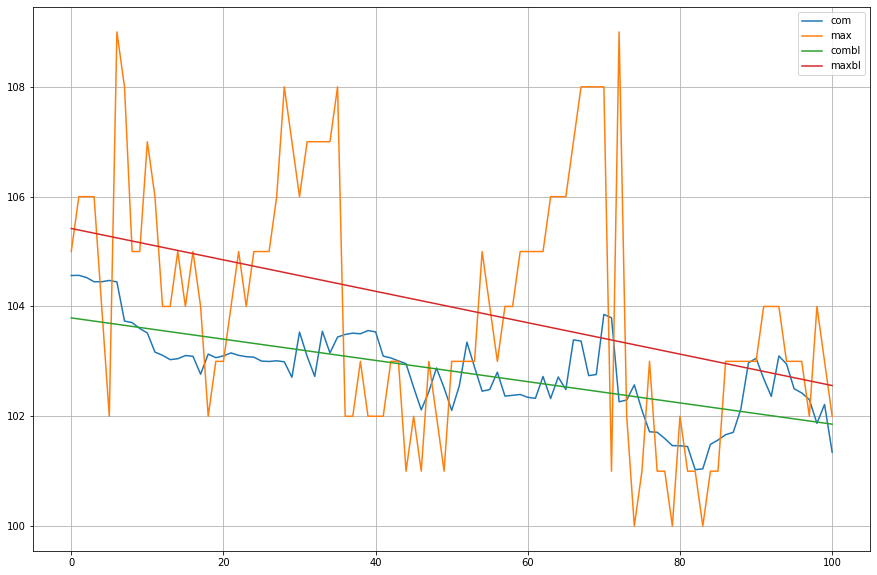

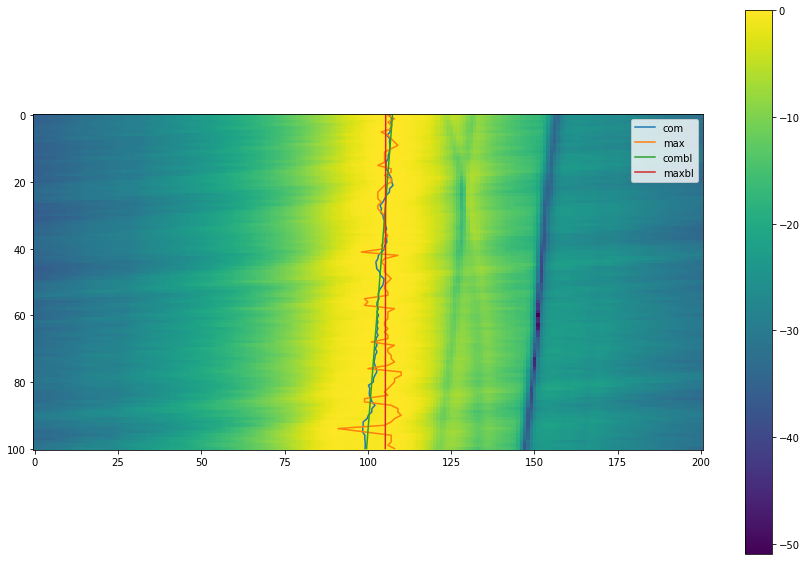

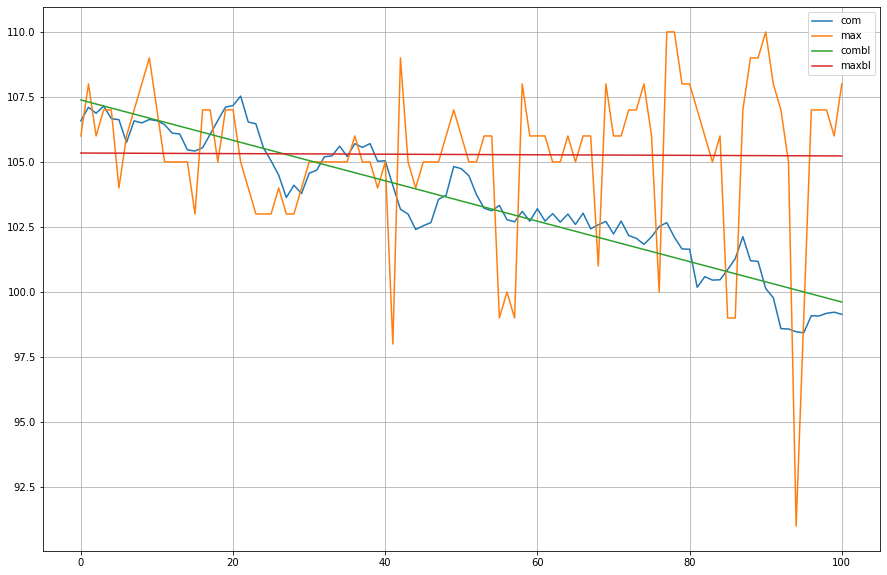

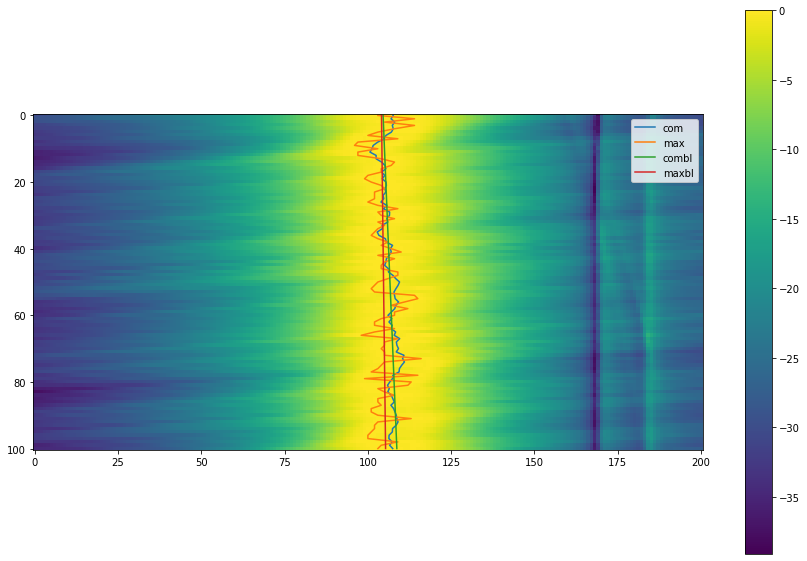

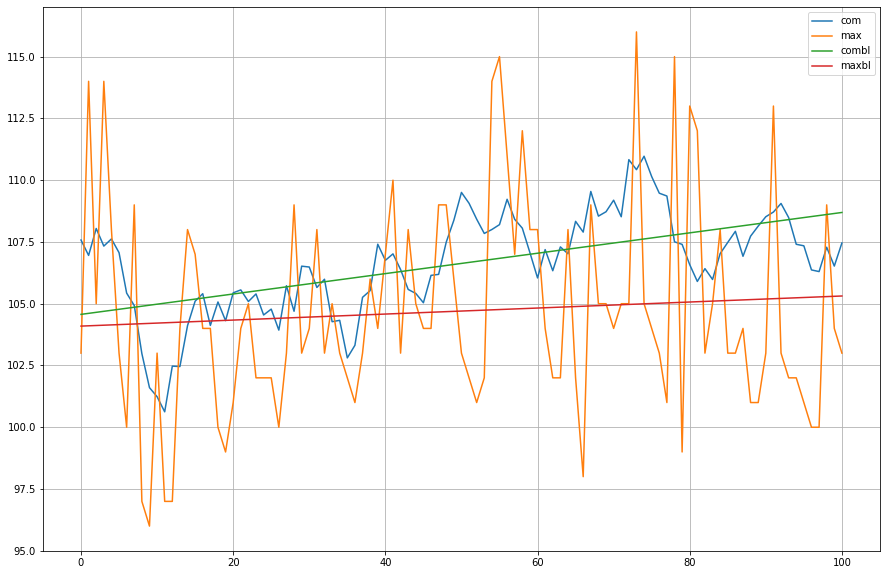

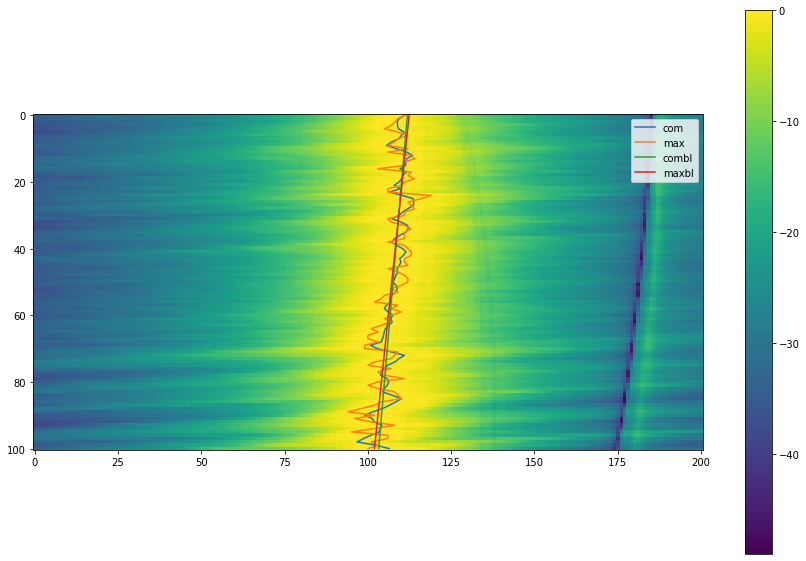

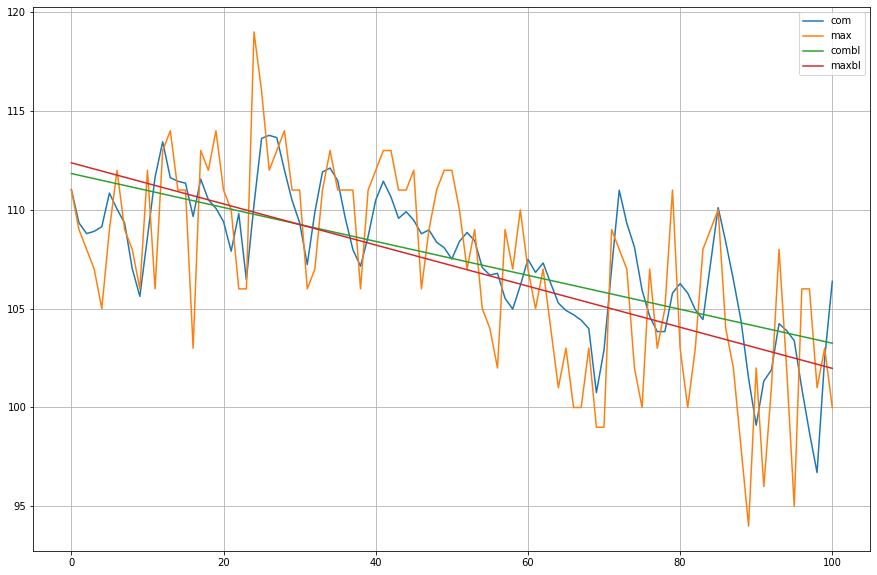

In [26]:

ftm = loadData('coarse_tuning_fine_measurements')
coarseData = loadData('coarse_filter_parameters')

print(ftm.keys())
def computeCenterOfMass(s21Mag):
    ns=s21Mag.shape[1]
    massPositionProduct=np.multiply(s21Mag,np.arange(ns))
    massPositionProductSum=np.sum(massPositionProduct, axis=1)
    centerOfMass = massPositionProductSum/np.sum(s21Mag,axis=1)
    return centerOfMass

def computeCenterOfMassLim(s21Mag, lim):
    rows, numSamp=s21Mag.shape
    centerOfMass=[]
    for r in range(rows):
        currentLine = s21Mag[r,:]
        valids = currentLine >= lim
        s21sel=currentLine[valids]
        idxSel=np.arange(numSamp)[valids]
        massPositionProduct=np.multiply(s21sel,idxSel)
        massPositionProductSum=np.sum(massPositionProduct)
        centerOfMass.append(massPositionProductSum/np.sum(s21sel))
    return np.array(centerOfMass)

def indexToFrequency(idx, fmap):
    rows, cols = fmap.shape
    iax = np.arange(cols)
    fs=[]
    for row in np.arange(rows):
        fs.append(np.interp(idx[row], iax, fmap[row,:]))
    return np.array(fs)

def analyzeFilterData(s21, freqMap, words):
    s21Mag=np.abs(s21)
    rows=s21Mag.shape[0]
    ya = np.arange(rows)
    
    peakValues = np.max(s21Mag, axis=1)
    s21Norm = s21Mag / peakValues[:,None]

    centerOfMass = computeCenterOfMassLim(s21Mag, 0.5)
    centerOfMassCoeff = np.polyfit(ya, centerOfMass, deg=1)
    centerOfMassFunc = np.poly1d(centerOfMassCoeff)
    
    #compute peak center
    peaks = np.argmax(s21Mag, axis=1)
    peaksCoeff = np.polyfit(ya, peaks, deg=1)
    peaksFunc = np.poly1d(peaksCoeff)
    
    plt.figure();
    plt.imshow(dB(s21Norm))
    plt.plot(centerOfMass.T, ya, label='com')
    plt.plot(peaks.T, ya, label='max')
    plt.plot(centerOfMassFunc(ya), ya, label='combl')
    plt.plot(peaksFunc(ya), ya, label='maxbl')
    plt.colorbar()
    plt.legend()
    plt.figure()
    plt.plot(ya, centerOfMass.T, label='com')
    plt.plot(ya, peaks.T, label='max')
    plt.plot(ya, centerOfMassFunc(ya), label='combl')
    plt.plot(ya, peaksFunc(ya), label='maxbl')
    plt.grid(True)
    plt.legend()


    centerOfMassFreqs = indexToFrequency(centerOfMass, freqMap)
    linCoeff = np.polyfit(centerOfMassFreqs, words, deg=1)
    k, m = linCoeff
    print("K %f [LSB/MHz] M %f [LSB]"%(k*1e6, m))
    return k, m


ks=[]
ms=[]

for a in range(6):
    baseKey='filter%d'%(a)
    s21=ftm[baseKey+'Map']
    freqMap = ftm[baseKey+'SpanMap']
    words = np.squeeze(ftm[baseKey+'TuningWords'])
    
    k, m = analyzeFilterData(s21, freqMap, words)
    ks.append(k)
    ms.append(m)

    
fineTuned={'k':ks, 'm':ms}
saveData('fine_filter_parameters2', fineTuned)



## Check fine tuned parameters

In [27]:
a = loadData('fine_filter_parameters2')
import yig_filter_model

ks = a['k'][0]
ms = a['m'][0]
filterBank = []
for i in range(len(ks)):
    filterBank.append(yig_controller_test.YigFilter(fMin[i], fMax[i], ms[i], ks[i], yc, i, new=True))
    
calMeas = skrf.network.Network('cal_through.s2p')

fix = yig_filter_model.SimpleS21Fixture(calMeas.f, calMeas.s[:, 1, 0])

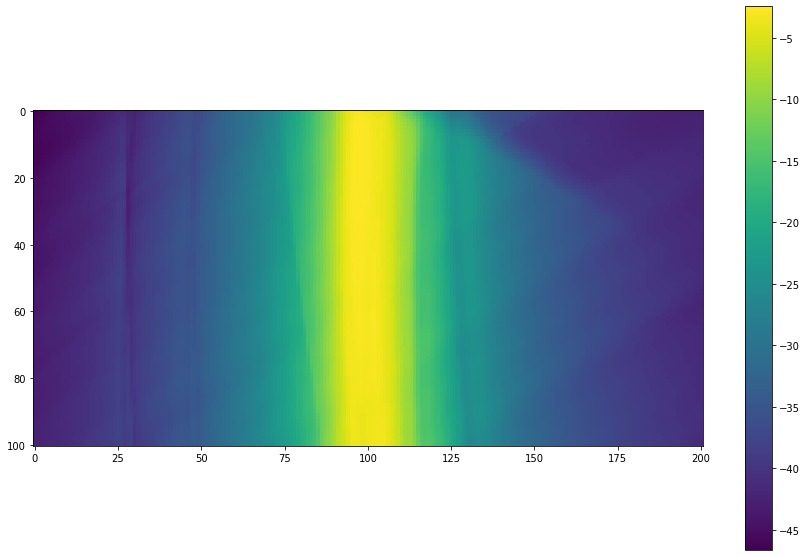

In [28]:
filter0Map, filter0TuningWords, filter0Frequencies, filter0SpanMap = measureYigFilter(filterBank[0])

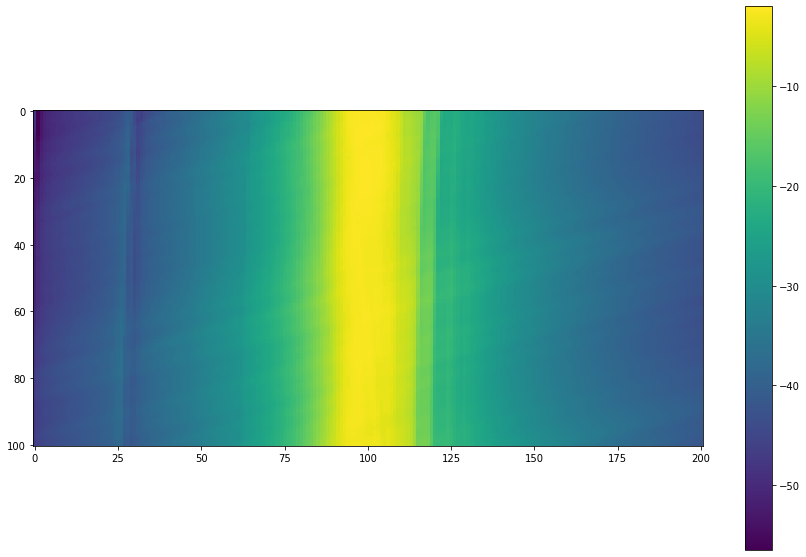

In [29]:
filter1Map, filter1TuningWords, filter1Frequencies, filter1SpanMap = measureYigFilter(filterBank[1])

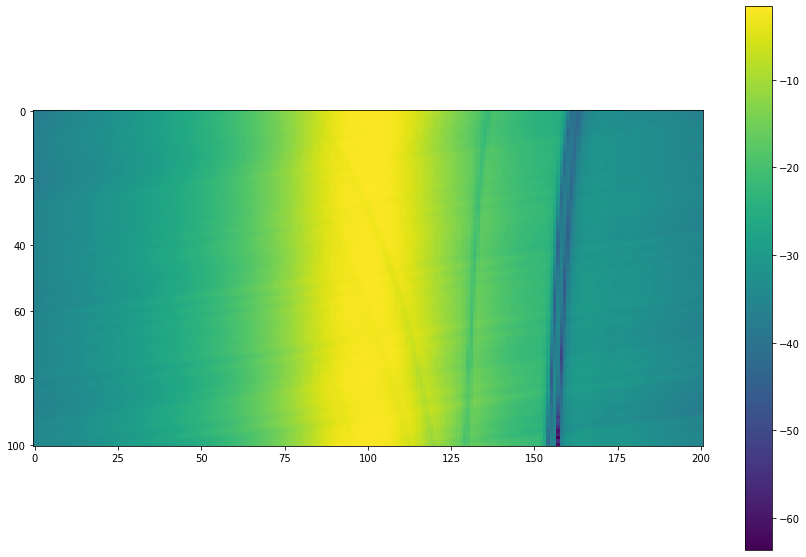

In [30]:
filter2Map, filter2TuningWords, filter2Frequencies, filter2SpanMap = measureYigFilter(filterBank[2])

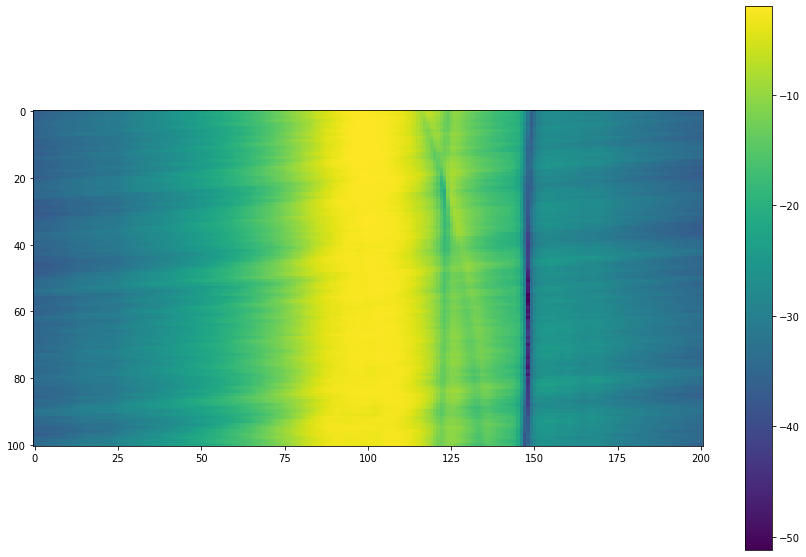

In [31]:
filter3Map, filter3TuningWords, filter3Frequencies, filter3SpanMap = measureYigFilter(filterBank[3])

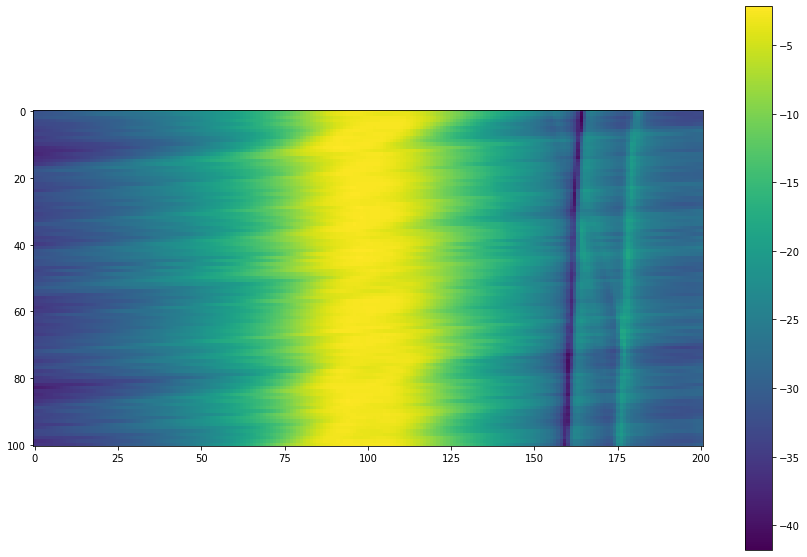

In [32]:
filter4Map, filter4TuningWords, filter4Frequencies, filter4SpanMap = measureYigFilter(filterBank[4])

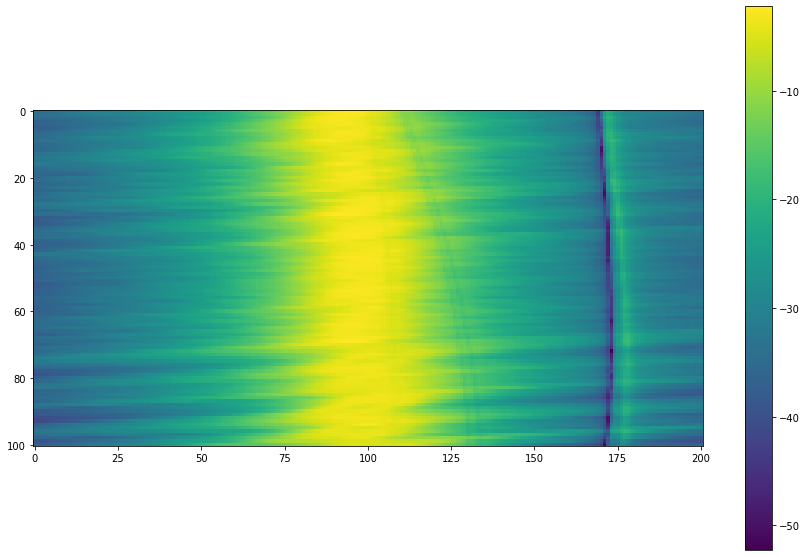

In [33]:
filter5Map, filter5TuningWords, filter5Frequencies, filter5SpanMap = measureYigFilter(filterBank[5])

In [34]:
saveDict={'filter0Map':filter0Map, 'filter0TuningWords':filter0TuningWords, 'filter0Frequencies':filter0Frequencies, 'filter0SpanMap':filter0SpanMap, 
          'filter1Map':filter1Map, 'filter1TuningWords':filter1TuningWords, 'filter1Frequencies':filter1Frequencies, 'filter1SpanMap':filter1SpanMap, 
          'filter2Map':filter2Map, 'filter2TuningWords':filter2TuningWords, 'filter2Frequencies':filter2Frequencies, 'filter2SpanMap':filter2SpanMap, 
          'filter3Map':filter3Map, 'filter3TuningWords':filter3TuningWords, 'filter3Frequencies':filter3Frequencies, 'filter3SpanMap':filter3SpanMap, 
          'filter4Map':filter4Map, 'filter4TuningWords':filter4TuningWords, 'filter4Frequencies':filter4Frequencies, 'filter4SpanMap':filter4SpanMap, 
          'filter5Map':filter5Map, 'filter5TuningWords':filter5TuningWords, 'filter5Frequencies':filter5Frequencies, 'filter5SpanMap':filter5SpanMap, }
saveData('fine_tuning_fine_measurements', saveDict)

filter 0 Coarse k 0.0241218523454352 [MHZ/lsb] coarse m 700.3325386005564 [MHz]
filter 0 fine   k 0.024831719222392405 [MHZ/lsb] cfine  m 690.3558350478482 [MHz]
filter 1 Coarse k 0.07196908374452055 [MHZ/lsb] coarse m 1993.16292379378 [MHz]
filter 1 fine   k 0.07162933687151793 [MHZ/lsb] cfine  m 1990.0179034093887 [MHz]
filter 2 Coarse k 0.16606777266491143 [MHZ/lsb] coarse m 4540.321805500824 [MHz]
filter 2 fine   k 0.16579300473245467 [MHZ/lsb] cfine  m 4545.216971488011 [MHz]
filter 3 Coarse k 0.33045817044833675 [MHZ/lsb] coarse m 8968.003953340221 [MHz]
filter 3 fine   k 0.33182464825517605 [MHZ/lsb] cfine  m 8963.729055262178 [MHz]
filter 4 Coarse k 0.30481777066971216 [MHZ/lsb] coarse m 8359.10667944045 [MHz]
filter 4 fine   k 0.3040393399034246 [MHZ/lsb] cfine  m 8358.832946184772 [MHz]
filter 5 Coarse k 0.3589626704519638 [MHZ/lsb] coarse m 9900.515912403282 [MHz]
filter 5 fine   k 0.3594463276845364 [MHZ/lsb] cfine  m 9887.565999764958 [MHz]


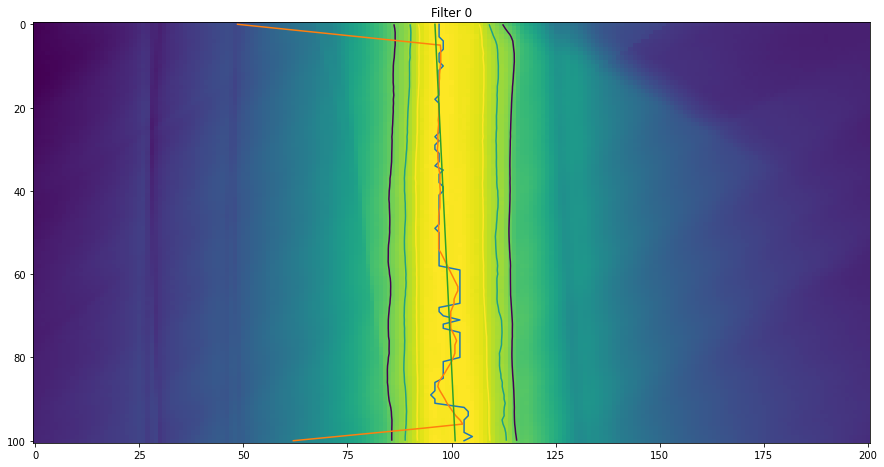

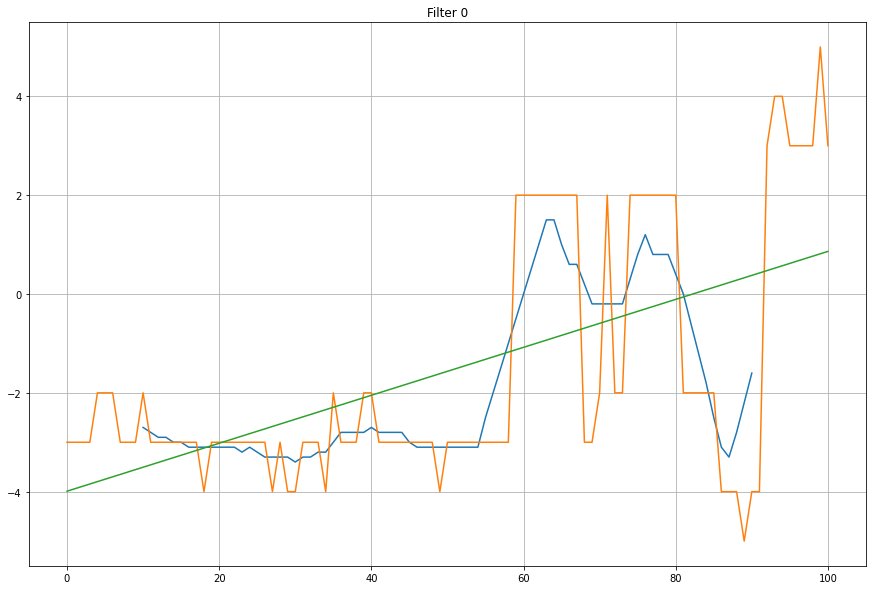

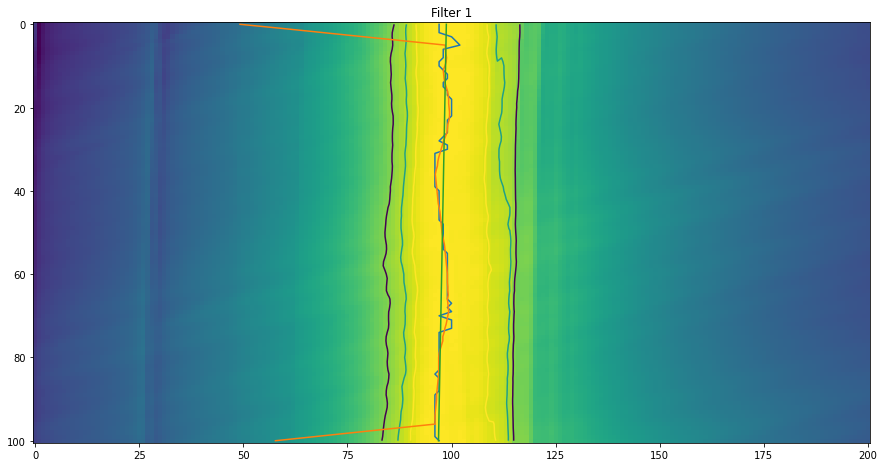

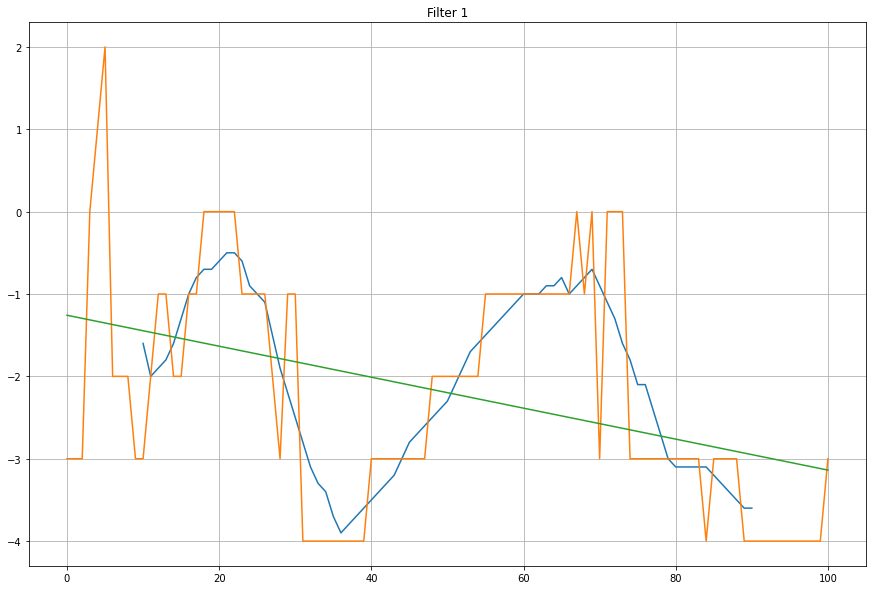

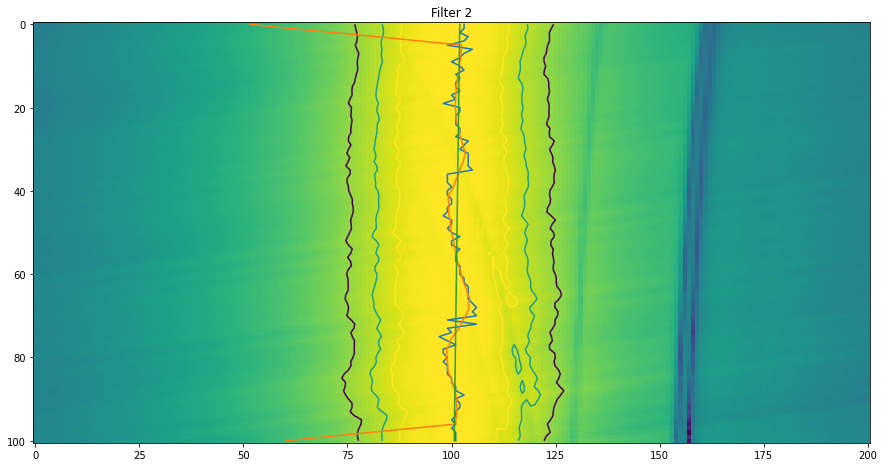

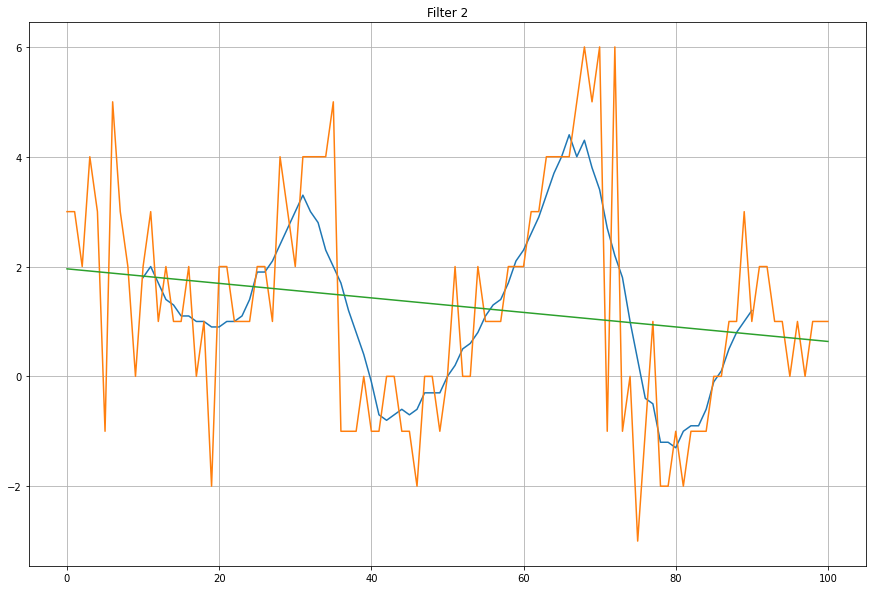

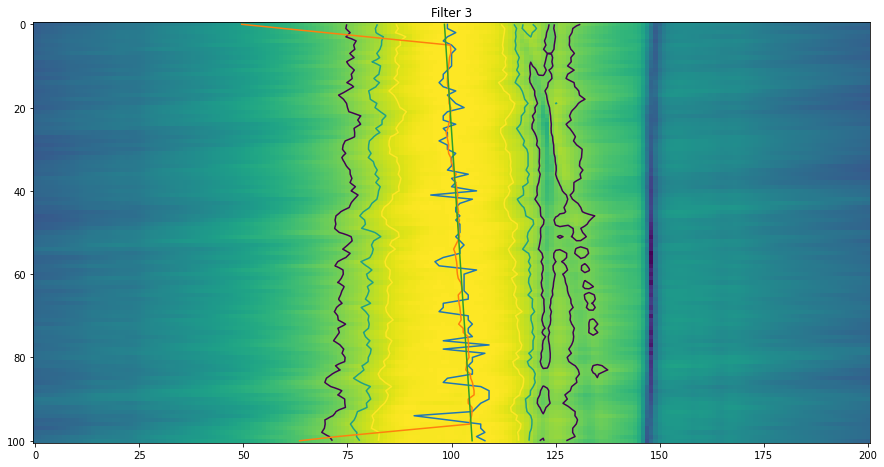

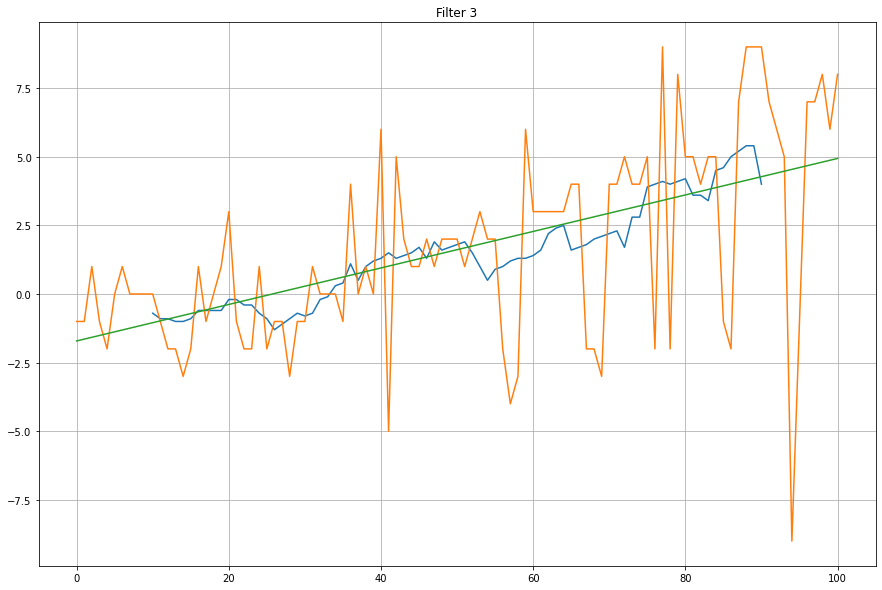

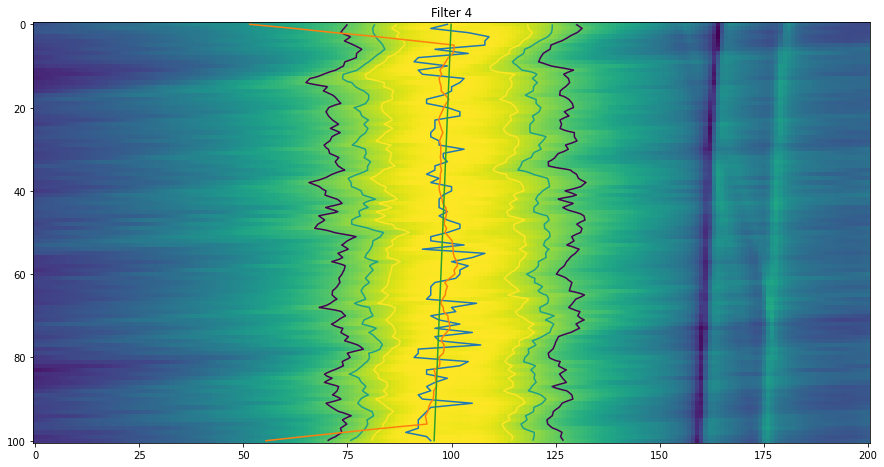

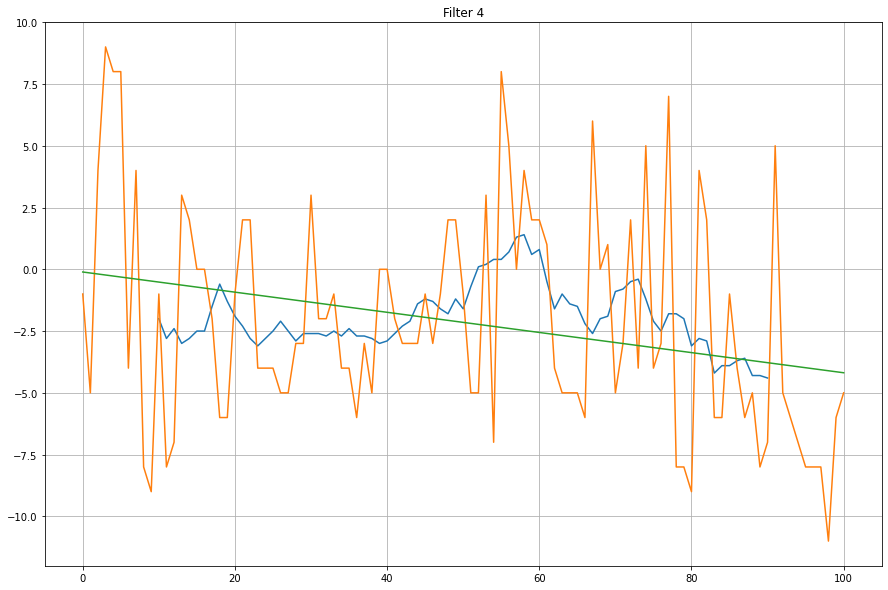

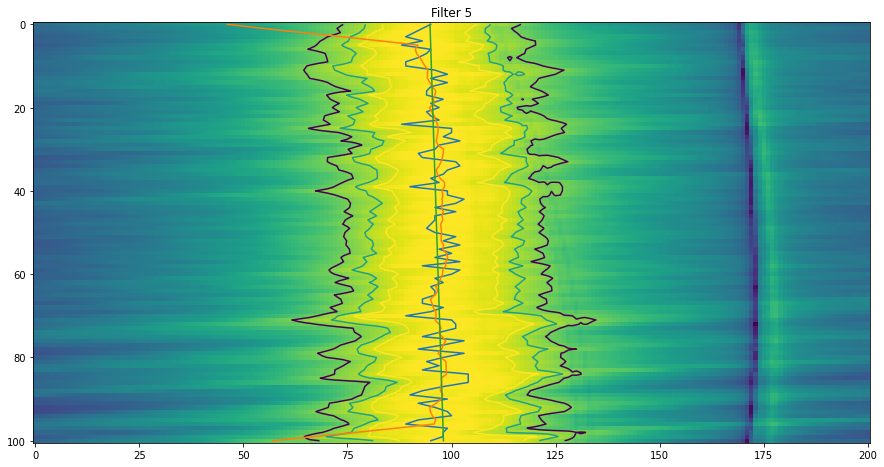

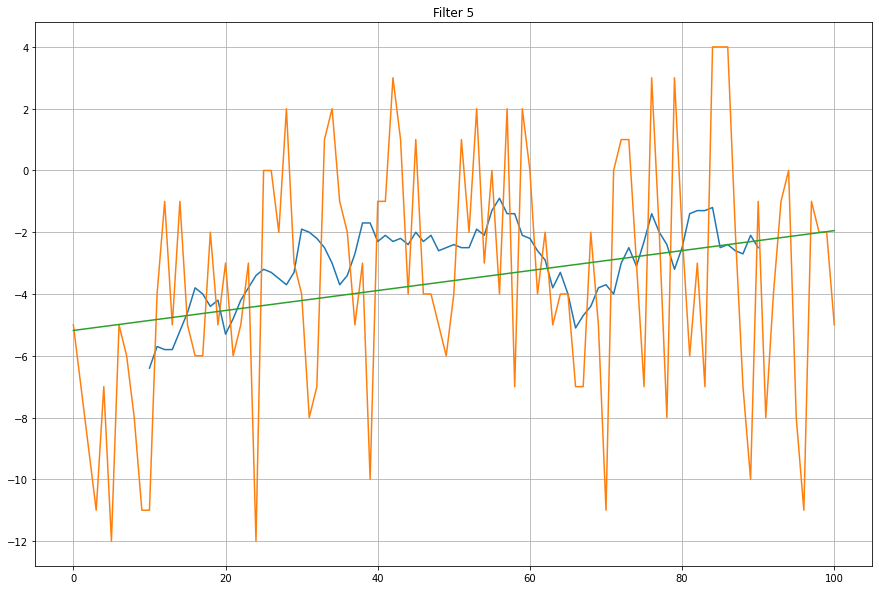

In [35]:
ftm = loadData('fine_tuning_fine_measurements')

coarseData = loadData('fine_filter_parameters')

kcoarse = coarseData['k'][0]
mcoarse = coarseData['m'][0]    
kfine = kcoarse
mfine = mcoarse

for i in range(6):
    k, m = fineTuneAnalysis(ftm, i)
    print("filter",i,"Coarse k", kcoarse[i], "[MHZ/lsb]", "coarse m", mcoarse[i], "[MHz]")
    kfine[i] = kcoarse[i] + k
    mfine[i] = mcoarse[i] + m
    print("filter",i,"fine   k", kfine[i], "[MHZ/lsb]", "cfine  m", mfine[i], "[MHz]")
    
fineTuned={'k':kfine, 'm':mfine}
#saveData('fine_filter_parameters', fineTuned)

## Upload coefficients 

In [36]:
a = loadData('fine_filter_parameters2')

ks = a['k'][0]
ms = a['m'][0]
#filterBank = []
for i in range(len(ks)):
    print
    yigDriver.writeFilterSlope(i, ks[i])
    time.sleep(0.2)
    yigDriver.writeFilterOffset(i, ms[i])
    time.sleep(0.2)
    yigDriver.writeFilterLowLim(i, fMin[i])
    time.sleep(0.2)
    yigDriver.writeFilterHighLim(i, fMax[i])
    time.sleep(0.2)
    #print(yigDriver.dev.read())
yigDriver.save()
time.sleep(0.2)
    #filterBank.append(yig_controller_test.YigFilter(fMin[i], fMax[i], ms[i]*1e6, ks[i]*1e6, yc, i))
    
#fc = 0.7e9
#spanHalf=500e6/2;
#vna.setStartFrequency(fc-spanHalf)
#vna.setStopFrequency(fc+spanHalf)
#filterBank[0].tuneTo(fc, channel=yigDriver)
#switch.set(1)
#vna.readSParameter('S21')
#yc.yigA.set(6,32700)